In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle
from matplotlib import style
import pickle

all_data = pd.read_csv("C:/Users/tmanett/Desktop/Uprising/Daily_2K_Player_Stats_Report_2023_Positionss.csv", skiprows=1)

all_data

Person_id          Player                     Team  GP  Min  FGM  FGA   
0      1600246              DT                 76ers GC  31  949   89  187  \
1      1630398             630                 76ers GC  31  949  247  398   
2      1630400             Dre                 76ers GC  31  949  197  368   
3      1630420  UnderRatedGoat                 76ers GC  31  949  127  186   
4      1630973              DJ                 76ers GC  31  949  210  256   
..         ...             ...                      ...  ..  ...  ...  ...   
123    1600022         Newdini  Wizards District Gaming  12  312   60   94   
124    1630073    Just Awkward  Wizards District Gaming  12  312   41   72   
125    1630970         Witness  Wizards District Gaming  12  312   62  115   
126    1630978            Kapp  Wizards District Gaming  12  312   74  167   
127    1641596          Gloski  Wizards District Gaming  12  312   36   76   

       FG%  FG3M  FG3A  ...  OREB  DREB  REB  AST  PF  STL  TOV  BLK  PTS   
0    0.476    70   141  ...    17   113  130   55  69   43   25   32  254  \
1    0.621    95   197  ...     1     9   10  147  52   37   66    0  627   
2    0.535   122   254  ...     1    16   17  253  41   23   75    1  566   
3    0.683    33    57  ...    18    19   37   32  63   42   13    4  293   
4    0.820     0     0  ...   113   211  324   92  33   28   45   30  442   
..     ...   ...   ...  ...   ...   ...  ...  ...  ..  ...  ...  ...  ...   
123  0.638    11    18  ...    36    63   99   26  21   20   18   10  140   
124  0.569    14    23  ...    11    15   26   13  33   21   12    6  101   
125  0.539    30    66  ...     0     3    3   39  30    6   15    0  155   
126  0.443    32    92  ...     0    11   11   83  21    2   29    1  209   
127  0.474    11    33  ...    28    55   83   20  22   11   17    5   85   

     Pos.  
0      PF  
1      SG  
2      PG  
3      SF  
4       C  
..    ...  
123    PF  
124    SF  
125    SG  
126    PG  
127    PF  

[128 rows x 24 columns]

### Offensive Rankings 

In [2]:
all_data["Minor_Possessions"] = all_data['FGA'] + 0.44 * all_data['FTA'] + all_data['TOV']
all_data["Major_Possessions"] = all_data['FGA'] + 0.44 * all_data['FTA'] - all_data['OREB'] + all_data['TOV']

team_assists = all_data.groupby('Team')['AST'].sum()
team_made_field_goals = all_data.groupby('Team')['FGM'].sum()

# Next, calculate the ratio of assists to made field goals for each team
team_assists_to_made_field_goals = team_assists / team_made_field_goals

# Merge the calculated ratio back into the 'team_stats' DataFrame
all_data = pd.merge(all_data, team_assists_to_made_field_goals.rename('TmAst_TmFGM'), left_on='Team', right_index=True)

num_players = 5 
player_min = 24

# Step 1: Calculate individual player's assists per minute (Ast/Min)
all_data['Ast_Per_Min'] = all_data['AST'] / player_min

# Step 2: Calculate team's average assists per minute (TmAst/(TmMin/5))
team_avg_ast_per_min = all_data.groupby('Team').apply(lambda x: x['AST'].sum() / (len(x) * player_min)).reset_index()
team_avg_ast_per_min.columns = ['Team', 'Tm_Avg_Ast_Per_Min']

# Step 3: Merge the team's average assists per minute back into the 'all_data' DataFrame
all_data = pd.merge(all_data, team_avg_ast_per_min, on='Team', how='left')

# Step 4: Calculate the desired ratio (Ast/Min relative to TmAst/(TmMin/5))
all_data['Ratio_Ast_Per_Min'] = all_data['Ast_Per_Min'] / all_data['Tm_Avg_Ast_Per_Min']

In [3]:
# Step 1: Calculate individual player's offensive rebounds per minute (OReb/Min)
all_data['OReb_Per_Min'] = all_data['OREB'] / player_min

# Step 2: Calculate the number of offensive rebounds per 48 minutes
all_data['Off_Reb_Per_48_Min'] = all_data['OReb_Per_Min'] * 48

In [4]:
# Step 1: Calculate individual player's Usage using 'Major_Possessions'
all_data['Usage'] = all_data['Major_Possessions'] / (player_min / num_players)

# Step 1: Calculate (3A/FGA)^2
all_data['Three_Point_Efficiency'] = (all_data['FG3A'] / all_data['FGA']) ** 2

# Step 3: Calculate (1/Usage)^2
all_data['Usage_Efficiency'] = (1 / all_data['Usage']) ** 2

# Step 4: Calculate the final shooting efficiency metric
all_data['Shooting_Efficiency'] = all_data['Three_Point_Efficiency'] * all_data['Usage_Efficiency']

In [5]:
# Calculate the complete formula with an absolute value
all_data['Complete_Formula'] = abs(all_data['TmAst_TmFGM'] * (1.53 - 1.442 * (all_data['Ast_Per_Min'] / all_data['Tm_Avg_Ast_Per_Min']) - 
                                                     0.041 * ((all_data['OREB'] / player_min) * 48) - 
                                                     0.787 * all_data['Usage'] + 
                                                     0.014 * all_data['Shooting_Efficiency']))


In [6]:
# Step 9: Calculate Points Created (PC) using the 'Complete_Formula' column
all_data['PC'] = all_data['Complete_Formula'] * all_data['FGM'] * 0.75

# Step 10: Calculate the estimated assisted field goals (Afgm)
all_data['Afgm'] = all_data['AST'] * 0.5

# Step 11: Calculate Possessions (Pos) using the formula provided
all_data['Pos'] = all_data['FGA'] + (0.44 * all_data['FTA']) + all_data['TOV'] + (0.375 * all_data['AST']) - all_data['Afgm']

# Step 12: Calculate Offensive Rating
all_data['Offensive_Rating'] = (all_data['PC'] / all_data['Pos']) * 100

all_data["PPG"] = all_data["PTS"] / all_data["GP"]

all_data["OER"] = all_data["PF"] / (all_data["FGA"] - all_data["OREB"] + all_data["TOV"] + 0.44 * all_data["FTA"])

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Person_id               128 non-null    int64  
 1   Player                  128 non-null    object 
 2   Team                    128 non-null    object 
 3   GP                      128 non-null    int64  
 4   Min                     128 non-null    int64  
 5   FGM                     128 non-null    int64  
 6   FGA                     128 non-null    int64  
 7   FG%                     128 non-null    float64
 8   FG3M                    128 non-null    int64  
 9   FG3A                    128 non-null    int64  
 10  FG3%                    128 non-null    float64
 11  FTM                     128 non-null    int64  
 12  FTA                     128 non-null    int64  
 13  FT%                     128 non-null    float64
 14  OREB                    128 non-null    in

PG Comparison 

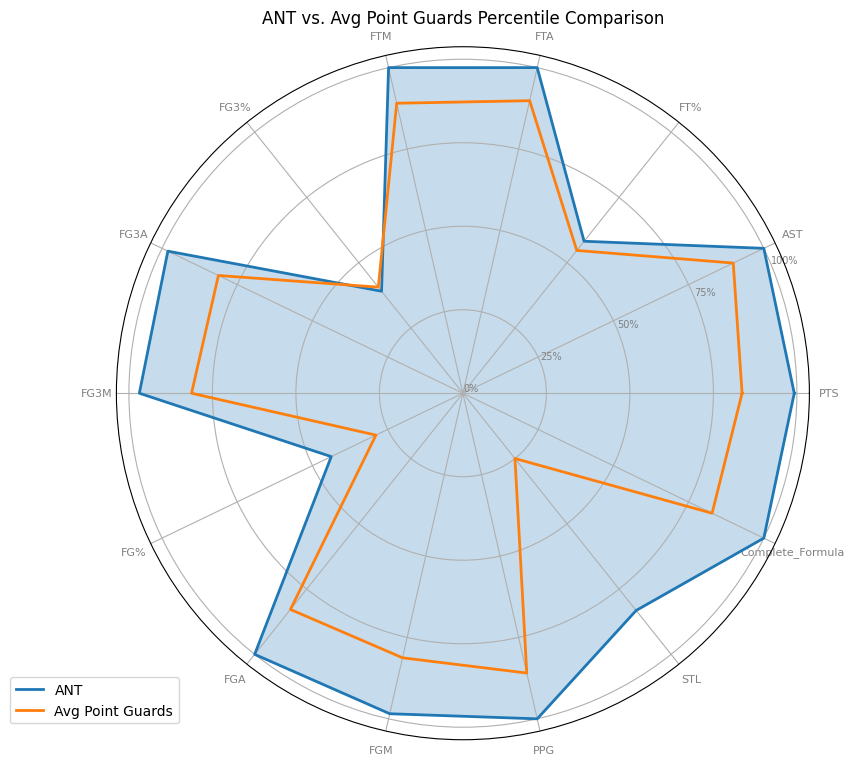

Player: ANT
PTS: 611 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 83.59%)
AST: 280 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 89.84%)
FT%: 0.968 (Player Percentile: 58.20%) (Avg Point Guards Percentile: 54.69%)
FTA: 63 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 89.84%)
FTM: 61 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.438 (Player Percentile: 39.06%) (Avg Point Guards Percentile: 40.62%)
FG3A: 201 (Player Percentile: 98.05%) (Avg Point Guards Percentile: 81.25%)
FG3M: 88 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.565 (Player Percentile: 43.75%) (Avg Point Guards Percentile: 28.91%)
FGA: 409 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 82.81%)
FGM: 231 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 81.25%)
PPG: 26.565217391304348 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 85.94%)
STL: 34 (Player Percentile: 83.20%) (Avg Point Guards Percenti

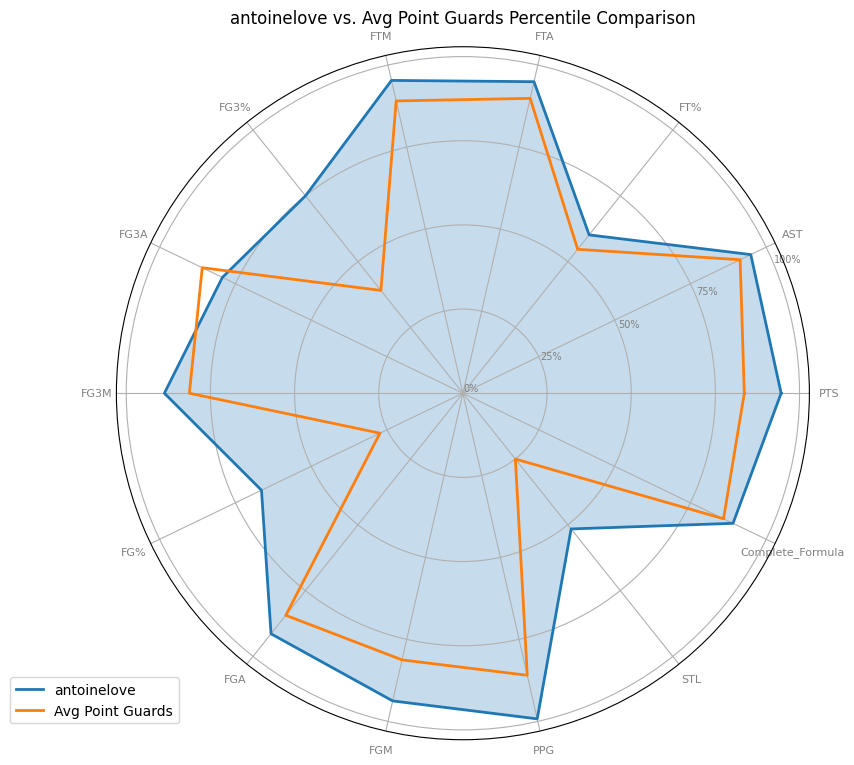

Player: antoinelove
PTS: 498 (Player Percentile: 94.53%) (Avg Point Guards Percentile: 83.59%)
AST: 168 (Player Percentile: 94.92%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.976 (Player Percentile: 60.16%) (Avg Point Guards Percentile: 54.69%)
FTA: 41 (Player Percentile: 94.92%) (Avg Point Guards Percentile: 89.84%)
FTM: 40 (Player Percentile: 95.31%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.515 (Player Percentile: 75.00%) (Avg Point Guards Percentile: 39.06%)
FG3A: 136 (Player Percentile: 79.30%) (Avg Point Guards Percentile: 85.94%)
FG3M: 70 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.616 (Player Percentile: 66.41%) (Avg Point Guards Percentile: 27.34%)
FGA: 315 (Player Percentile: 91.41%) (Avg Point Guards Percentile: 84.38%)
FGM: 194 (Player Percentile: 93.75%) (Avg Point Guards Percentile: 81.25%)
PPG: 26.210526315789473 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 85.94%)
STL: 19 (Player Percentile: 51.56%) (Avg Point Guards Perce

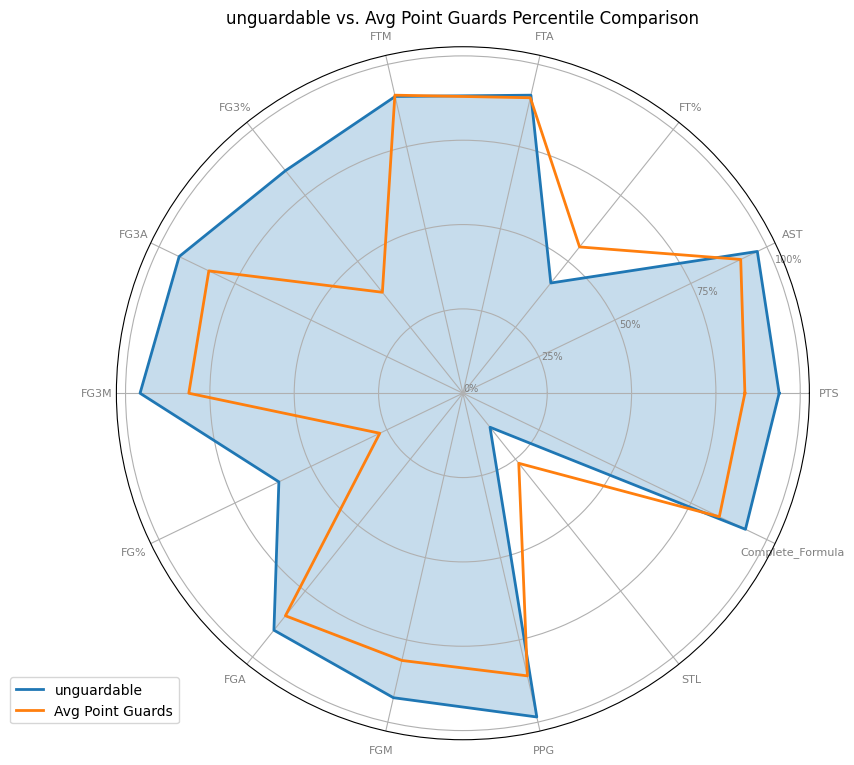

Player: unguardable
PTS: 495 (Player Percentile: 93.75%) (Avg Point Guards Percentile: 83.59%)
AST: 204 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.917 (Player Percentile: 41.80%) (Avg Point Guards Percentile: 55.47%)
FTA: 36 (Player Percentile: 90.62%) (Avg Point Guards Percentile: 89.84%)
FTM: 33 (Player Percentile: 90.23%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.541 (Player Percentile: 84.38%) (Avg Point Guards Percentile: 38.28%)
FG3A: 159 (Player Percentile: 93.36%) (Avg Point Guards Percentile: 83.59%)
FG3M: 86 (Player Percentile: 95.70%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.606 (Player Percentile: 60.55%) (Avg Point Guards Percentile: 27.34%)
FGA: 310 (Player Percentile: 89.84%) (Avg Point Guards Percentile: 84.38%)
FGM: 188 (Player Percentile: 92.58%) (Avg Point Guards Percentile: 81.25%)
PPG: 26.05263157894737 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 85.94%)
STL: 9 (Player Percentile: 12.89%) (Avg Point Guards Percent

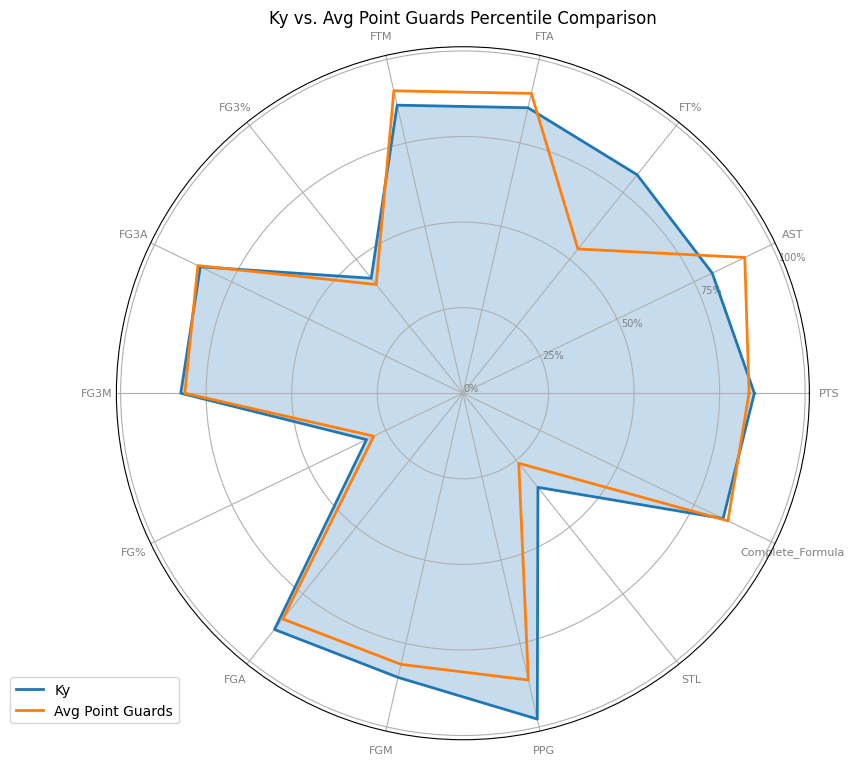

Player: Ky
PTS: 413 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 83.59%)
AST: 104 (Player Percentile: 80.86%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 29 (Player Percentile: 85.55%) (Avg Point Guards Percentile: 89.84%)
FTM: 29 (Player Percentile: 86.33%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.451 (Player Percentile: 42.97%) (Avg Point Guards Percentile: 40.62%)
FG3A: 142 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 85.94%)
FG3M: 64 (Player Percentile: 82.42%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.539 (Player Percentile: 31.25%) (Avg Point Guards Percentile: 28.91%)
FGA: 297 (Player Percentile: 88.28%) (Avg Point Guards Percentile: 84.38%)
FGM: 160 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 81.25%)
PPG: 25.8125 (Player Percentile: 97.66%) (Avg Point Guards Percentile: 85.94%)
STL: 15 (Player Percentile: 35.16%) (Avg Point Guards Percentile: 26.17%)
Complet

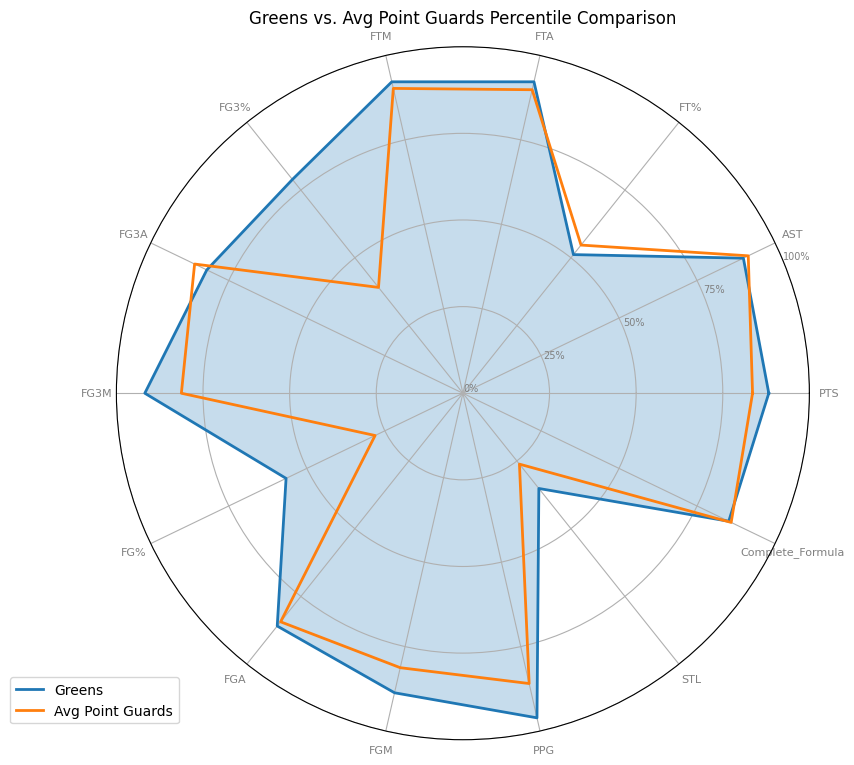

Player: Greens
PTS: 441 (Player Percentile: 88.28%) (Avg Point Guards Percentile: 83.59%)
AST: 145 (Player Percentile: 89.84%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.947 (Player Percentile: 51.17%) (Avg Point Guards Percentile: 54.69%)
FTA: 38 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 89.84%)
FTM: 36 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 90.23%)
FG3%: 0.521 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 39.06%)
FG3A: 140 (Player Percentile: 82.03%) (Avg Point Guards Percentile: 85.94%)
FG3M: 73 (Player Percentile: 91.80%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.591 (Player Percentile: 56.64%) (Avg Point Guards Percentile: 28.12%)
FGA: 281 (Player Percentile: 85.94%) (Avg Point Guards Percentile: 84.38%)
FGM: 166 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 81.25%)
PPG: 24.5 (Player Percentile: 96.09%) (Avg Point Guards Percentile: 85.94%)
STL: 15 (Player Percentile: 35.16%) (Avg Point Guards Percentile: 26.17%)
Comp

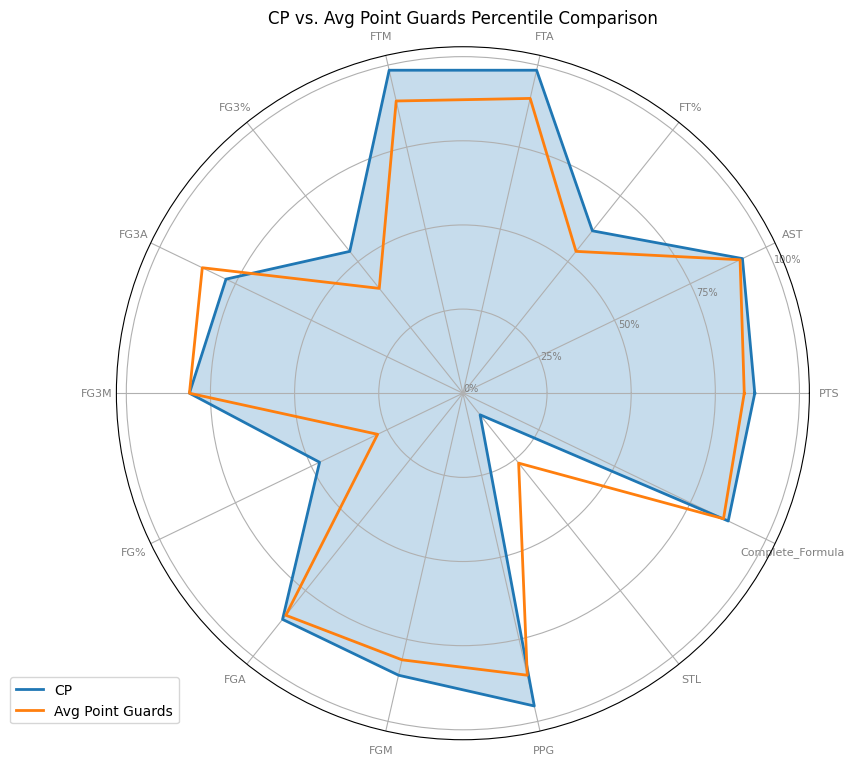

Player: CP
PTS: 436 (Player Percentile: 86.72%) (Avg Point Guards Percentile: 83.59%)
AST: 155 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.981 (Player Percentile: 61.72%) (Avg Point Guards Percentile: 53.91%)
FTA: 53 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 89.84%)
FTM: 52 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.473 (Player Percentile: 53.91%) (Avg Point Guards Percentile: 39.84%)
FG3A: 131 (Player Percentile: 78.12%) (Avg Point Guards Percentile: 85.94%)
FG3M: 62 (Player Percentile: 81.25%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.573 (Player Percentile: 47.27%) (Avg Point Guards Percentile: 28.12%)
FGA: 281 (Player Percentile: 85.94%) (Avg Point Guards Percentile: 84.38%)
FGM: 161 (Player Percentile: 85.94%) (Avg Point Guards Percentile: 81.25%)
PPG: 24.22222222222222 (Player Percentile: 95.31%) (Avg Point Guards Percentile: 85.94%)
STL: 7 (Player Percentile: 8.20%) (Avg Point Guards Percentile: 26.56

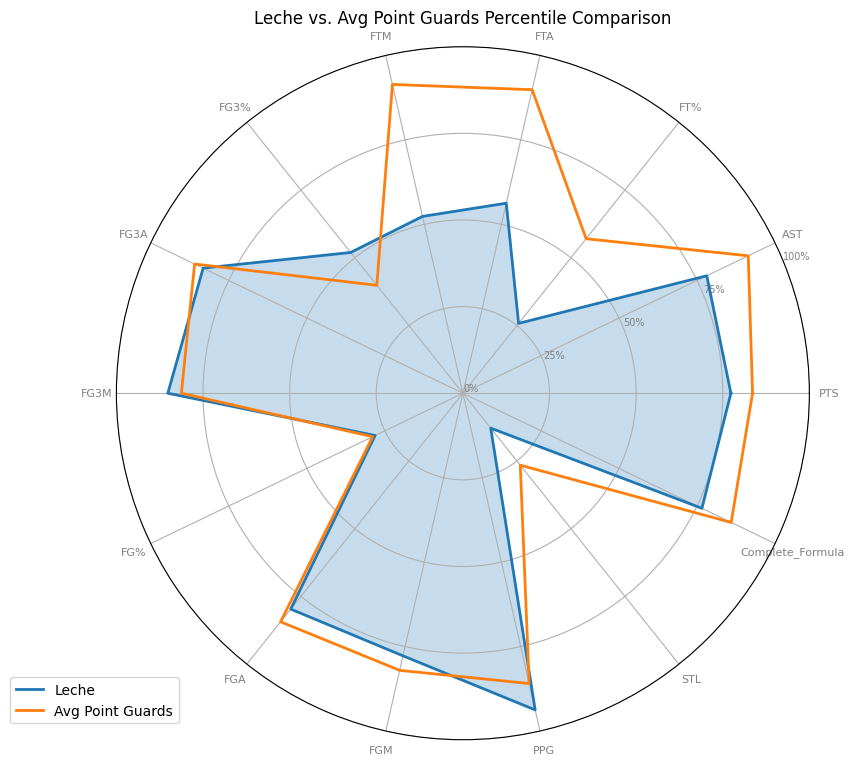

Player: Leche
PTS: 324 (Player Percentile: 77.34%) (Avg Point Guards Percentile: 83.59%)
AST: 97 (Player Percentile: 78.12%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.833 (Player Percentile: 25.78%) (Avg Point Guards Percentile: 57.03%)
FTA: 12 (Player Percentile: 56.25%) (Avg Point Guards Percentile: 89.84%)
FTM: 10 (Player Percentile: 52.34%) (Avg Point Guards Percentile: 91.41%)
FG3%: 0.468 (Player Percentile: 51.95%) (Avg Point Guards Percentile: 39.84%)
FG3A: 141 (Player Percentile: 83.20%) (Avg Point Guards Percentile: 85.94%)
FG3M: 66 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.532 (Player Percentile: 28.12%) (Avg Point Guards Percentile: 28.91%)
FGA: 233 (Player Percentile: 79.69%) (Avg Point Guards Percentile: 84.38%)
FGM: 124 (Player Percentile: 77.73%) (Avg Point Guards Percentile: 82.03%)
PPG: 23.142857142857142 (Player Percentile: 93.75%) (Avg Point Guards Percentile: 85.94%)
STL: 9 (Player Percentile: 12.89%) (Avg Point Guards Percentile: 2

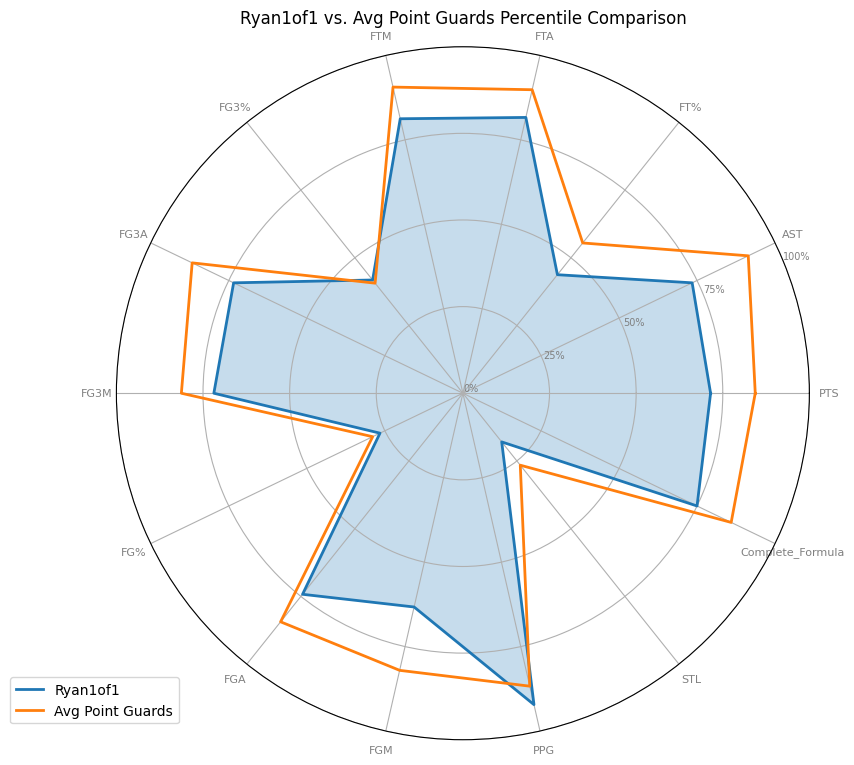

Player: Ryan1of1
PTS: 281 (Player Percentile: 71.48%) (Avg Point Guards Percentile: 84.38%)
AST: 75 (Player Percentile: 73.44%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.92 (Player Percentile: 43.75%) (Avg Point Guards Percentile: 55.47%)
FTA: 25 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 89.84%)
FTM: 23 (Player Percentile: 81.25%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.449 (Player Percentile: 41.80%) (Avg Point Guards Percentile: 40.62%)
FG3A: 107 (Player Percentile: 73.44%) (Avg Point Guards Percentile: 86.72%)
FG3M: 48 (Player Percentile: 71.88%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.528 (Player Percentile: 26.56%) (Avg Point Guards Percentile: 28.91%)
FGA: 199 (Player Percentile: 74.22%) (Avg Point Guards Percentile: 84.38%)
FGM: 105 (Player Percentile: 63.28%) (Avg Point Guards Percentile: 82.03%)
PPG: 21.615384615384617 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 86.72%)
STL: 10 (Player Percentile: 17.97%) (Avg Point Guards Percentile

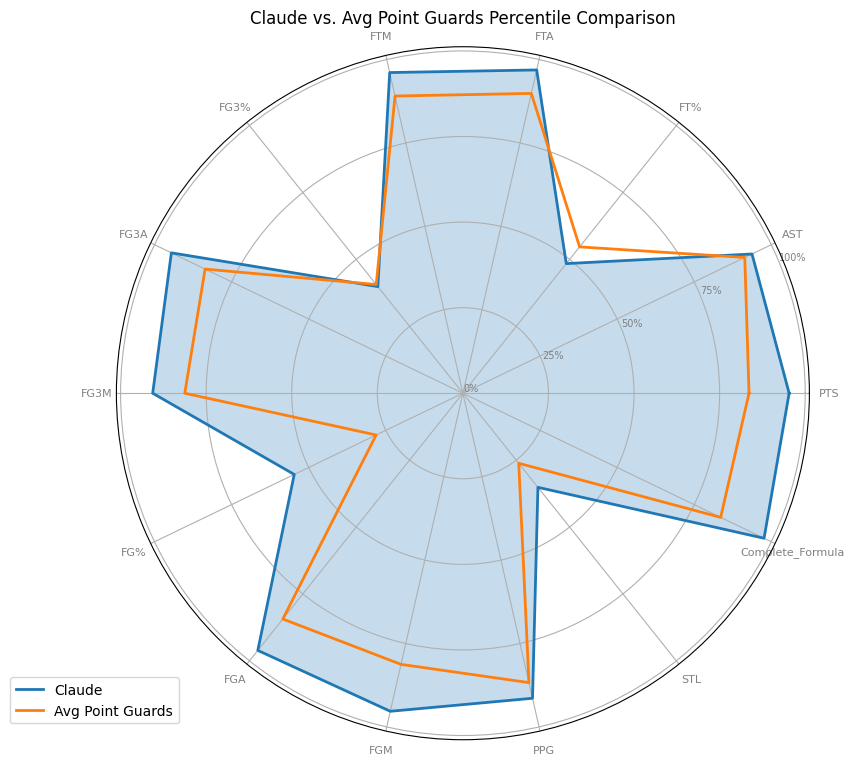

Player: Claude
PTS: 518 (Player Percentile: 95.31%) (Avg Point Guards Percentile: 83.59%)
AST: 167 (Player Percentile: 93.75%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.941 (Player Percentile: 48.44%) (Avg Point Guards Percentile: 54.69%)
FTA: 51 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 89.84%)
FTM: 48 (Player Percentile: 96.09%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.439 (Player Percentile: 39.84%) (Avg Point Guards Percentile: 40.62%)
FG3A: 164 (Player Percentile: 94.53%) (Avg Point Guards Percentile: 83.59%)
FG3M: 72 (Player Percentile: 90.62%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.587 (Player Percentile: 54.69%) (Avg Point Guards Percentile: 28.12%)
FGA: 339 (Player Percentile: 96.09%) (Avg Point Guards Percentile: 84.38%)
FGM: 199 (Player Percentile: 95.31%) (Avg Point Guards Percentile: 81.25%)
PPG: 21.583333333333332 (Player Percentile: 91.41%) (Avg Point Guards Percentile: 86.72%)
STL: 15 (Player Percentile: 35.16%) (Avg Point Guards Percentile

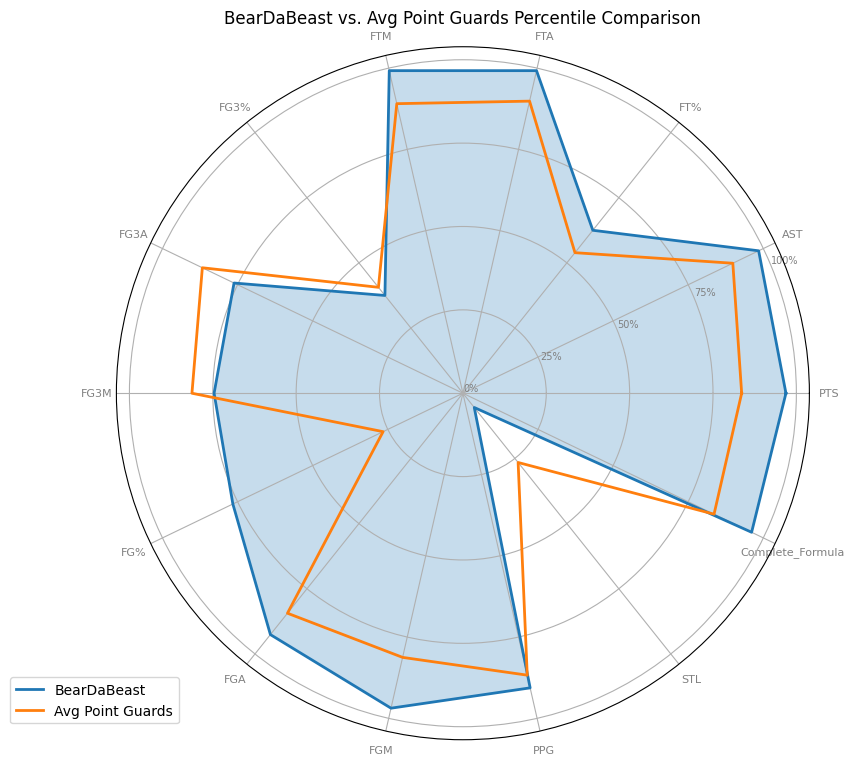

Player: BearDaBeast
PTS: 536 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 83.59%)
AST: 248 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 89.84%)
FT%: 0.983 (Player Percentile: 62.50%) (Avg Point Guards Percentile: 53.91%)
FTA: 60 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 89.84%)
FTM: 59 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.432 (Player Percentile: 37.50%) (Avg Point Guards Percentile: 40.62%)
FG3A: 118 (Player Percentile: 76.17%) (Avg Point Guards Percentile: 86.72%)
FG3M: 51 (Player Percentile: 74.61%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.666 (Player Percentile: 76.56%) (Avg Point Guards Percentile: 26.56%)
FGA: 320 (Player Percentile: 92.58%) (Avg Point Guards Percentile: 84.38%)
FGM: 213 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 81.25%)
PPG: 21.44 (Player Percentile: 90.62%) (Avg Point Guards Percentile: 86.72%)
STL: 6 (Player Percentile: 5.47%) (Avg Point Guards Percentile: 26.56%)


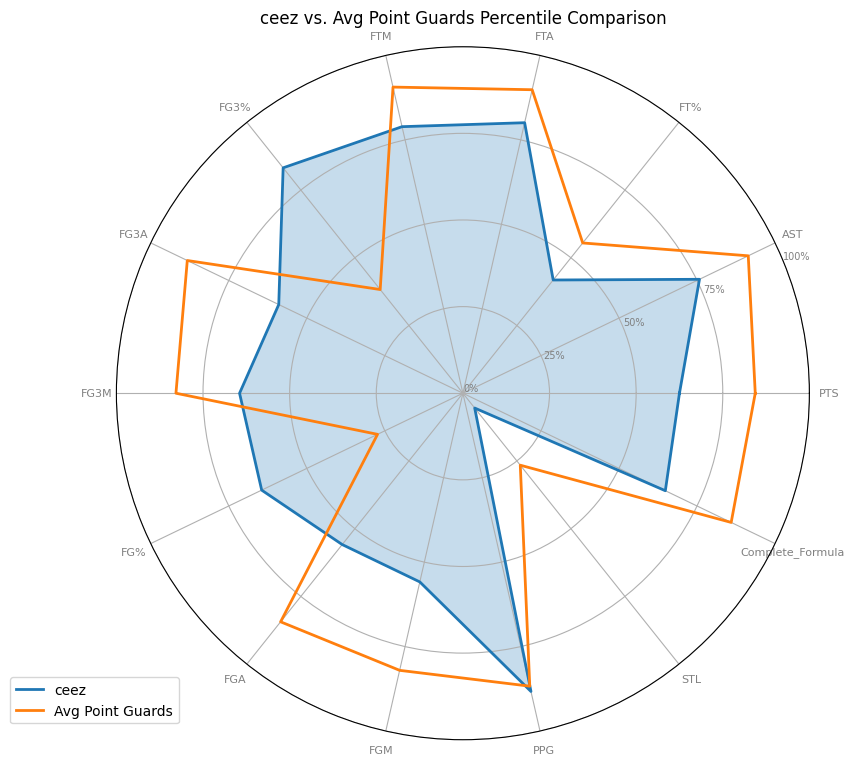

Player: ceez
PTS: 247 (Player Percentile: 62.50%) (Avg Point Guards Percentile: 84.38%)
AST: 87 (Player Percentile: 75.78%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.917 (Player Percentile: 41.80%) (Avg Point Guards Percentile: 55.47%)
FTA: 24 (Player Percentile: 80.08%) (Avg Point Guards Percentile: 89.84%)
FTM: 22 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.534 (Player Percentile: 83.20%) (Avg Point Guards Percentile: 38.28%)
FG3A: 73 (Player Percentile: 58.98%) (Avg Point Guards Percentile: 88.28%)
FG3M: 39 (Player Percentile: 64.45%) (Avg Point Guards Percentile: 82.81%)
FG%: 0.612 (Player Percentile: 64.45%) (Avg Point Guards Percentile: 27.34%)
FGA: 152 (Player Percentile: 55.86%) (Avg Point Guards Percentile: 84.38%)
FGM: 93 (Player Percentile: 55.86%) (Avg Point Guards Percentile: 82.03%)
PPG: 20.583333333333332 (Player Percentile: 88.28%) (Avg Point Guards Percentile: 86.72%)
STL: 6 (Player Percentile: 5.47%) (Avg Point Guards Percentile: 26.56

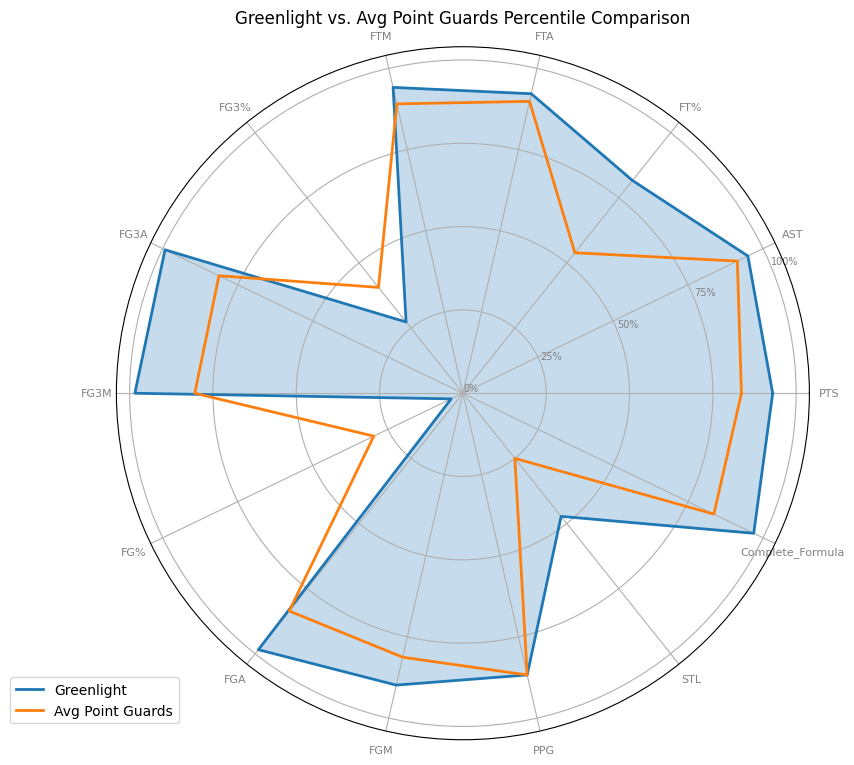

Player: Greenlight
PTS: 482 (Player Percentile: 92.97%) (Avg Point Guards Percentile: 83.59%)
AST: 168 (Player Percentile: 94.92%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 38 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 89.84%)
FTM: 38 (Player Percentile: 94.14%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.402 (Player Percentile: 27.34%) (Avg Point Guards Percentile: 40.62%)
FG3A: 234 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 81.25%)
FG3M: 94 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 80.47%)
FG%: 0.458 (Player Percentile: 3.91%) (Avg Point Guards Percentile: 29.69%)
FGA: 382 (Player Percentile: 98.44%) (Avg Point Guards Percentile: 83.59%)
FGM: 175 (Player Percentile: 89.84%) (Avg Point Guards Percentile: 81.25%)
PPG: 20.083333333333332 (Player Percentile: 86.72%) (Avg Point Guards Percentile: 86.72%)
STL: 18 (Player Percentile: 47.27%) (Avg Point Guards Percentil

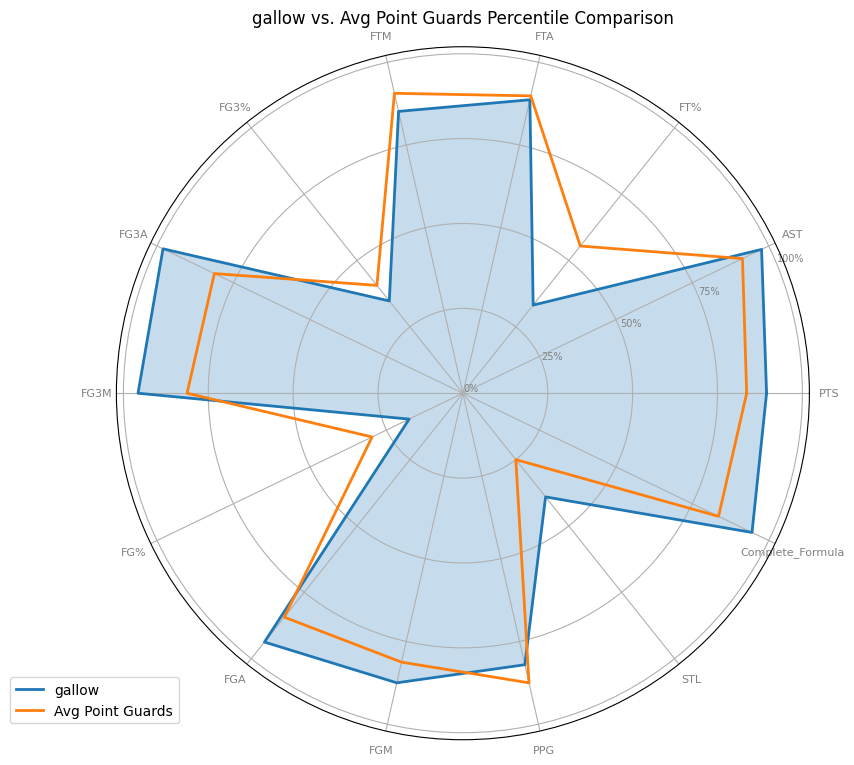

Player: gallow
PTS: 442 (Player Percentile: 89.45%) (Avg Point Guards Percentile: 83.59%)
AST: 210 (Player Percentile: 97.66%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.875 (Player Percentile: 33.20%) (Avg Point Guards Percentile: 55.47%)
FTA: 32 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 89.84%)
FTM: 28 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.428 (Player Percentile: 34.77%) (Avg Point Guards Percentile: 40.62%)
FG3A: 201 (Player Percentile: 98.05%) (Avg Point Guards Percentile: 81.25%)
FG3M: 86 (Player Percentile: 95.70%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.508 (Player Percentile: 17.58%) (Avg Point Guards Percentile: 29.69%)
FGA: 323 (Player Percentile: 93.75%) (Avg Point Guards Percentile: 84.38%)
FGM: 164 (Player Percentile: 87.50%) (Avg Point Guards Percentile: 81.25%)
PPG: 18.416666666666668 (Player Percentile: 82.03%) (Avg Point Guards Percentile: 87.50%)
STL: 16 (Player Percentile: 39.06%) (Avg Point Guards Percentile

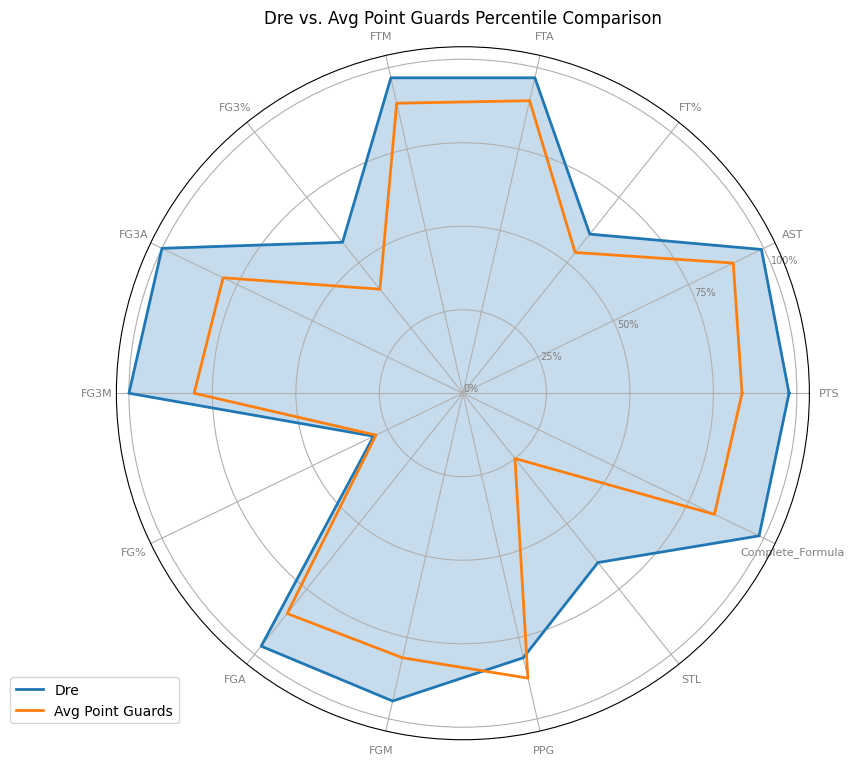

Player: Dre
PTS: 566 (Player Percentile: 97.66%) (Avg Point Guards Percentile: 83.59%)
AST: 253 (Player Percentile: 99.22%) (Avg Point Guards Percentile: 89.84%)
FT%: 0.98 (Player Percentile: 60.94%) (Avg Point Guards Percentile: 53.91%)
FTA: 51 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 89.84%)
FTM: 50 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.48 (Player Percentile: 57.81%) (Avg Point Guards Percentile: 39.84%)
FG3A: 254 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 79.69%)
FG3M: 122 (Player Percentile: 100.00%) (Avg Point Guards Percentile: 80.47%)
FG%: 0.535 (Player Percentile: 29.69%) (Avg Point Guards Percentile: 28.91%)
FGA: 368 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 84.38%)
FGM: 197 (Player Percentile: 94.53%) (Avg Point Guards Percentile: 81.25%)
PPG: 18.258064516129032 (Player Percentile: 81.25%) (Avg Point Guards Percentile: 87.50%)
STL: 23 (Player Percentile: 64.84%) (Avg Point Guards Percentile: 

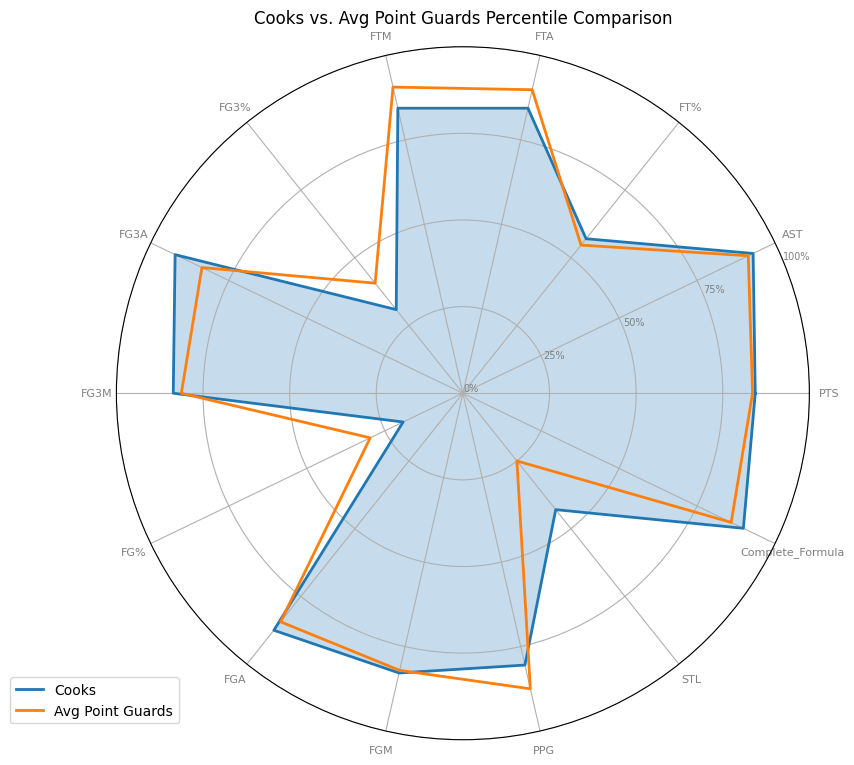

Player: Cooks
PTS: 382 (Player Percentile: 84.38%) (Avg Point Guards Percentile: 83.59%)
AST: 166 (Player Percentile: 92.97%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.964 (Player Percentile: 57.03%) (Avg Point Guards Percentile: 54.69%)
FTA: 28 (Player Percentile: 84.38%) (Avg Point Guards Percentile: 89.84%)
FTM: 27 (Player Percentile: 84.38%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.411 (Player Percentile: 30.86%) (Avg Point Guards Percentile: 40.62%)
FG3A: 158 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 83.59%)
FG3M: 65 (Player Percentile: 83.59%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.511 (Player Percentile: 19.14%) (Avg Point Guards Percentile: 29.69%)
FGA: 284 (Player Percentile: 87.50%) (Avg Point Guards Percentile: 84.38%)
FGM: 145 (Player Percentile: 82.81%) (Avg Point Guards Percentile: 82.03%)
PPG: 18.19047619047619 (Player Percentile: 80.47%) (Avg Point Guards Percentile: 87.50%)
STL: 17 (Player Percentile: 42.97%) (Avg Point Guards Percentile: 

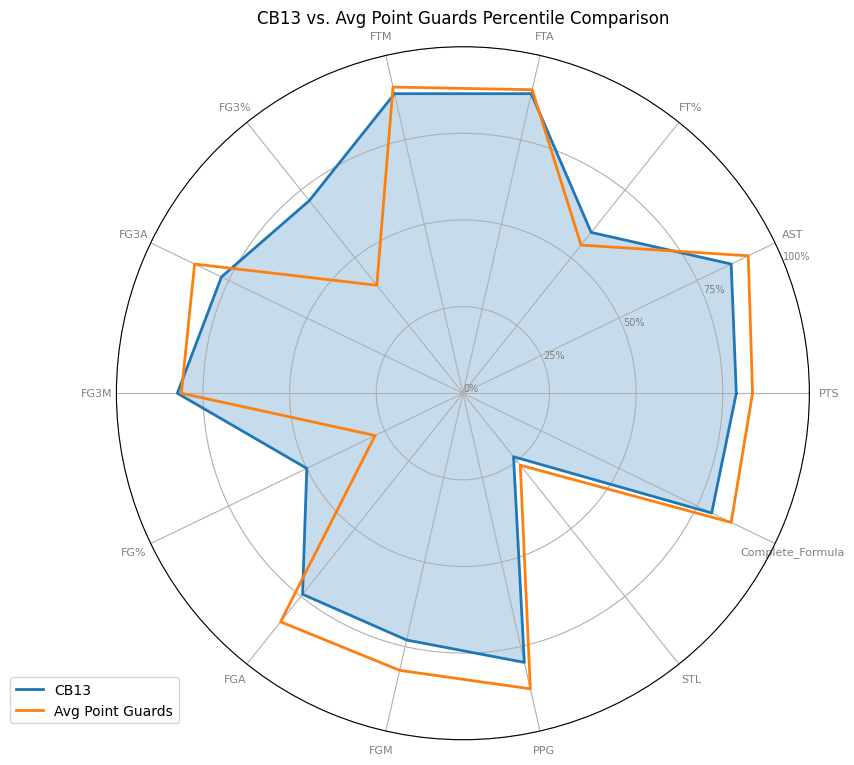

Player: CB13
PTS: 325 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 83.59%)
AST: 125 (Player Percentile: 85.94%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.969 (Player Percentile: 59.38%) (Avg Point Guards Percentile: 54.69%)
FTA: 32 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 89.84%)
FTM: 31 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.508 (Player Percentile: 71.09%) (Avg Point Guards Percentile: 39.84%)
FG3A: 126 (Player Percentile: 77.34%) (Avg Point Guards Percentile: 85.94%)
FG3M: 64 (Player Percentile: 82.42%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.578 (Player Percentile: 50.00%) (Avg Point Guards Percentile: 28.12%)
FGA: 199 (Player Percentile: 74.22%) (Avg Point Guards Percentile: 84.38%)
FGM: 115 (Player Percentile: 73.05%) (Avg Point Guards Percentile: 82.03%)
PPG: 18.055555555555557 (Player Percentile: 79.69%) (Avg Point Guards Percentile: 87.50%)
STL: 11 (Player Percentile: 23.44%) (Avg Point Guards Percentile: 

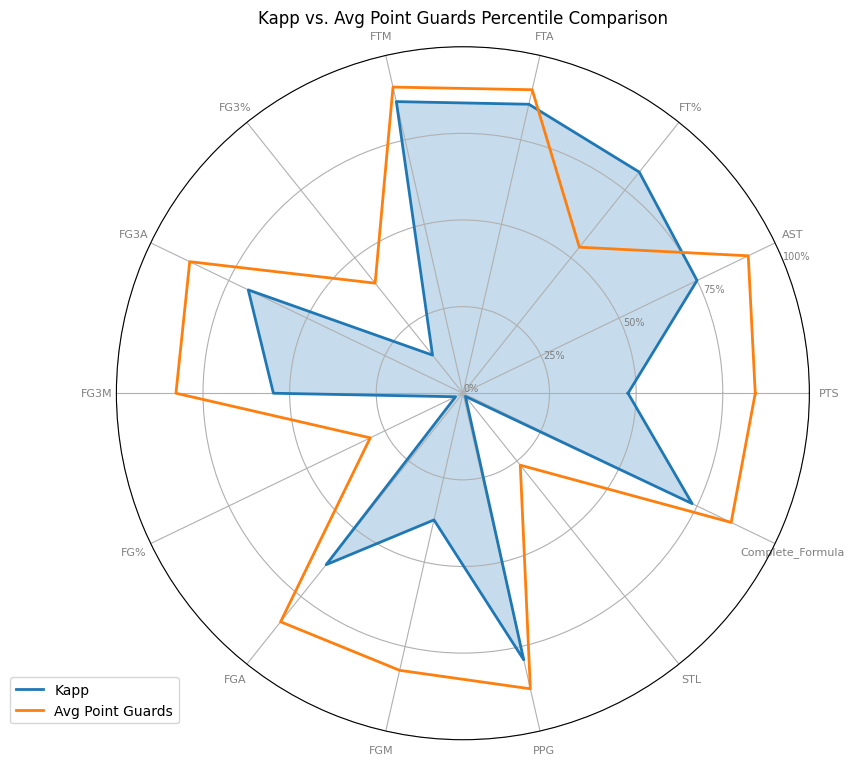

Player: Kapp
PTS: 209 (Player Percentile: 47.66%) (Avg Point Guards Percentile: 84.38%)
AST: 83 (Player Percentile: 75.00%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 29 (Player Percentile: 85.55%) (Avg Point Guards Percentile: 89.84%)
FTM: 29 (Player Percentile: 86.33%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.348 (Player Percentile: 14.06%) (Avg Point Guards Percentile: 40.62%)
FG3A: 92 (Player Percentile: 68.75%) (Avg Point Guards Percentile: 87.50%)
FG3M: 32 (Player Percentile: 54.69%) (Avg Point Guards Percentile: 82.81%)
FG%: 0.443 (Player Percentile: 2.34%) (Avg Point Guards Percentile: 29.69%)
FGA: 167 (Player Percentile: 63.28%) (Avg Point Guards Percentile: 84.38%)
FGM: 74 (Player Percentile: 37.50%) (Avg Point Guards Percentile: 82.03%)
PPG: 17.416666666666668 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 87.50%)
STL: 2 (Player Percentile: 1.17%) (Avg Point Guards Percentile: 26.56%)


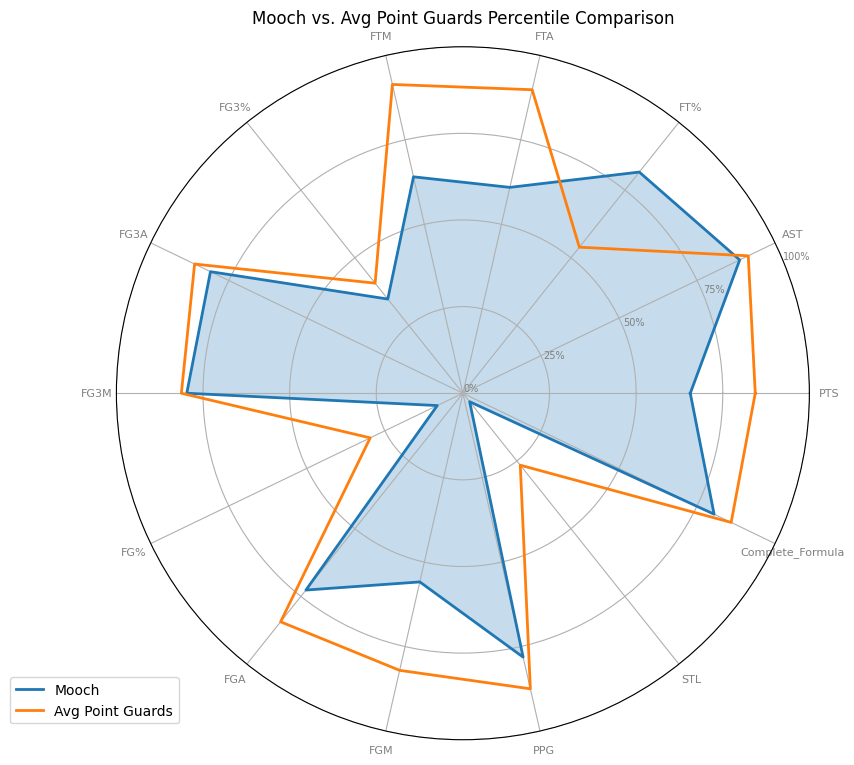

Player: Mooch
PTS: 258 (Player Percentile: 65.62%) (Avg Point Guards Percentile: 84.38%)
AST: 140 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 13 (Player Percentile: 60.94%) (Avg Point Guards Percentile: 89.84%)
FTM: 13 (Player Percentile: 64.06%) (Avg Point Guards Percentile: 91.41%)
FG3%: 0.428 (Player Percentile: 34.77%) (Avg Point Guards Percentile: 40.62%)
FG3A: 138 (Player Percentile: 80.86%) (Avg Point Guards Percentile: 85.94%)
FG3M: 59 (Player Percentile: 79.69%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.474 (Player Percentile: 8.20%) (Avg Point Guards Percentile: 29.69%)
FGA: 196 (Player Percentile: 72.66%) (Avg Point Guards Percentile: 84.38%)
FGM: 93 (Player Percentile: 55.86%) (Avg Point Guards Percentile: 82.03%)
PPG: 17.2 (Player Percentile: 78.12%) (Avg Point Guards Percentile: 87.50%)
STL: 5 (Player Percentile: 3.12%) (Avg Point Guards Percentile: 26.56%)
Complete_Fo

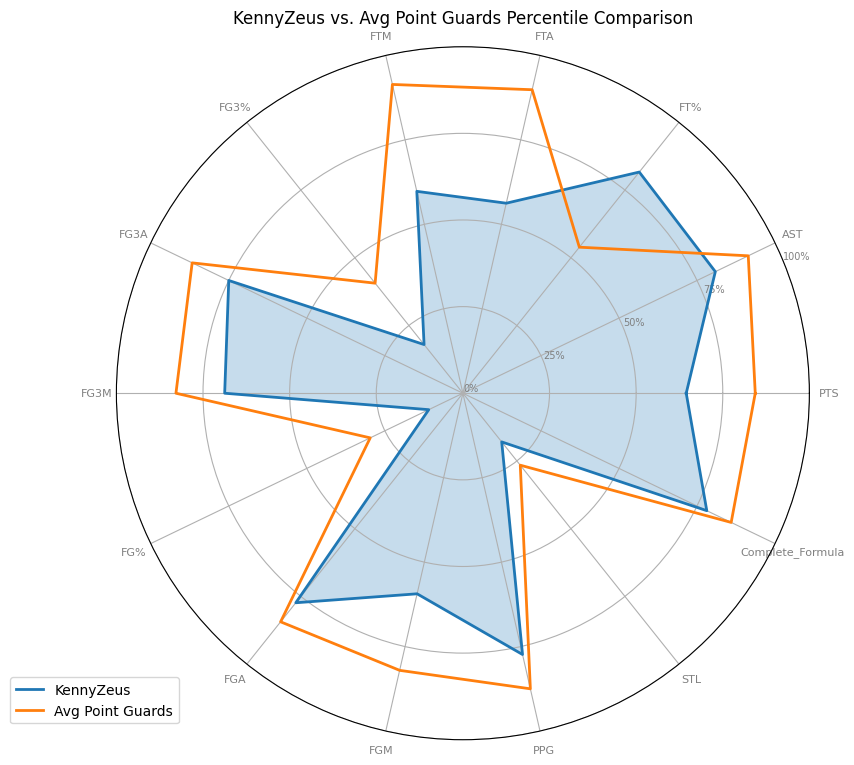

Player: KennyZeus
PTS: 254 (Player Percentile: 64.45%) (Avg Point Guards Percentile: 84.38%)
AST: 104 (Player Percentile: 80.86%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 12 (Player Percentile: 56.25%) (Avg Point Guards Percentile: 89.84%)
FTM: 12 (Player Percentile: 59.77%) (Avg Point Guards Percentile: 91.41%)
FG3%: 0.372 (Player Percentile: 17.97%) (Avg Point Guards Percentile: 40.62%)
FG3A: 113 (Player Percentile: 75.00%) (Avg Point Guards Percentile: 86.72%)
FG3M: 42 (Player Percentile: 68.75%) (Avg Point Guards Percentile: 82.81%)
FG%: 0.483 (Player Percentile: 10.94%) (Avg Point Guards Percentile: 29.69%)
FGA: 207 (Player Percentile: 77.34%) (Avg Point Guards Percentile: 84.38%)
FGM: 100 (Player Percentile: 59.38%) (Avg Point Guards Percentile: 82.03%)
PPG: 16.933333333333334 (Player Percentile: 77.34%) (Avg Point Guards Percentile: 87.50%)
STL: 10 (Player Percentile: 17.97%) (Avg Point Guards Percentil

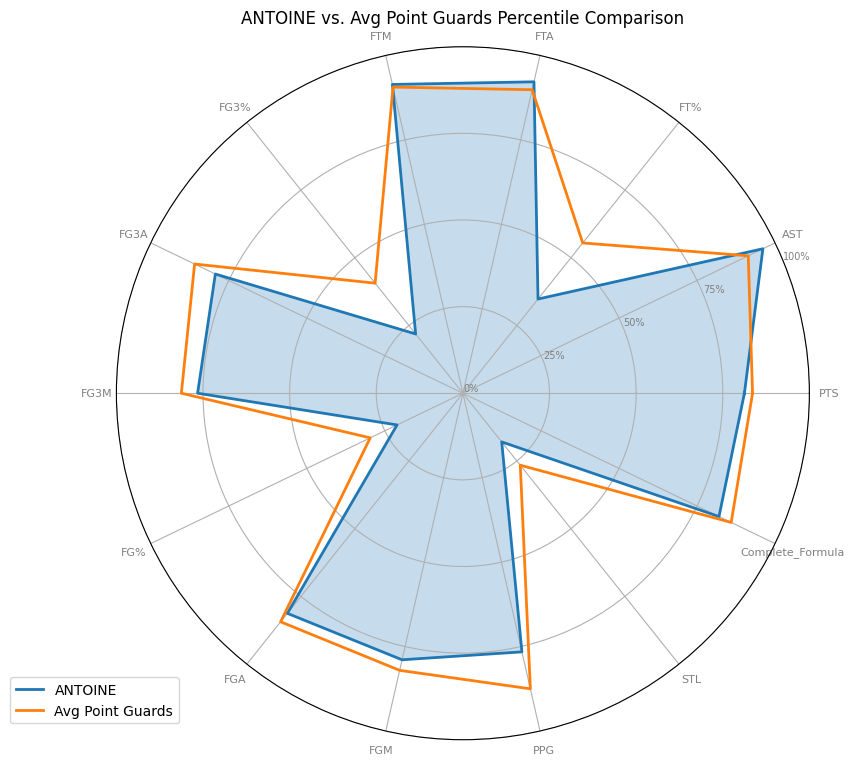

Player: ANTOINE
PTS: 337 (Player Percentile: 81.25%) (Avg Point Guards Percentile: 83.59%)
AST: 181 (Player Percentile: 96.09%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.895 (Player Percentile: 34.77%) (Avg Point Guards Percentile: 55.47%)
FTA: 38 (Player Percentile: 92.19%) (Avg Point Guards Percentile: 89.84%)
FTM: 34 (Player Percentile: 91.41%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.39 (Player Percentile: 21.88%) (Avg Point Guards Percentile: 40.62%)
FG3A: 136 (Player Percentile: 79.30%) (Avg Point Guards Percentile: 85.94%)
FG3M: 53 (Player Percentile: 76.56%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.514 (Player Percentile: 21.09%) (Avg Point Guards Percentile: 29.69%)
FGA: 243 (Player Percentile: 81.25%) (Avg Point Guards Percentile: 84.38%)
FGM: 125 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 82.03%)
PPG: 16.85 (Player Percentile: 76.56%) (Avg Point Guards Percentile: 87.50%)
STL: 10 (Player Percentile: 17.97%) (Avg Point Guards Percentile: 26.56%)
Com

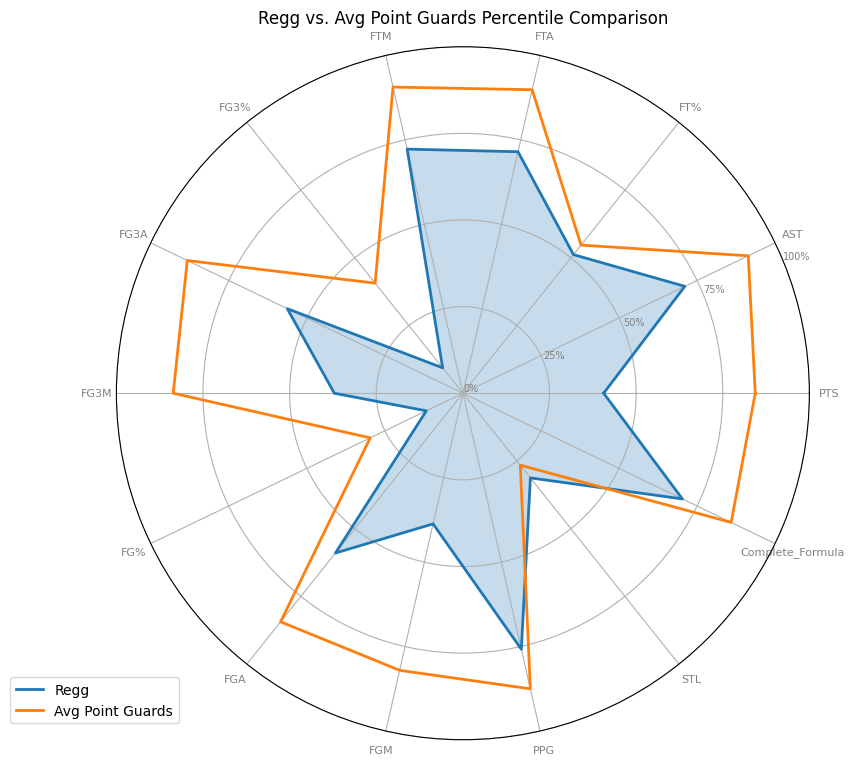

Player: Regg
PTS: 192 (Player Percentile: 40.62%) (Avg Point Guards Percentile: 84.38%)
AST: 66 (Player Percentile: 71.09%) (Avg Point Guards Percentile: 91.41%)
FT%: 0.947 (Player Percentile: 51.17%) (Avg Point Guards Percentile: 54.69%)
FTA: 19 (Player Percentile: 71.48%) (Avg Point Guards Percentile: 89.84%)
FTM: 18 (Player Percentile: 72.27%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.31 (Player Percentile: 9.38%) (Avg Point Guards Percentile: 40.62%)
FG3A: 71 (Player Percentile: 56.25%) (Avg Point Guards Percentile: 88.28%)
FG3M: 22 (Player Percentile: 37.11%) (Avg Point Guards Percentile: 83.59%)
FG%: 0.484 (Player Percentile: 11.72%) (Avg Point Guards Percentile: 29.69%)
FGA: 157 (Player Percentile: 58.98%) (Avg Point Guards Percentile: 84.38%)
FGM: 76 (Player Percentile: 38.67%) (Avg Point Guards Percentile: 82.03%)
PPG: 16.0 (Player Percentile: 75.78%) (Avg Point Guards Percentile: 87.50%)
STL: 14 (Player Percentile: 31.25%) (Avg Point Guards Percentile: 26.56%)
Complete_Fo

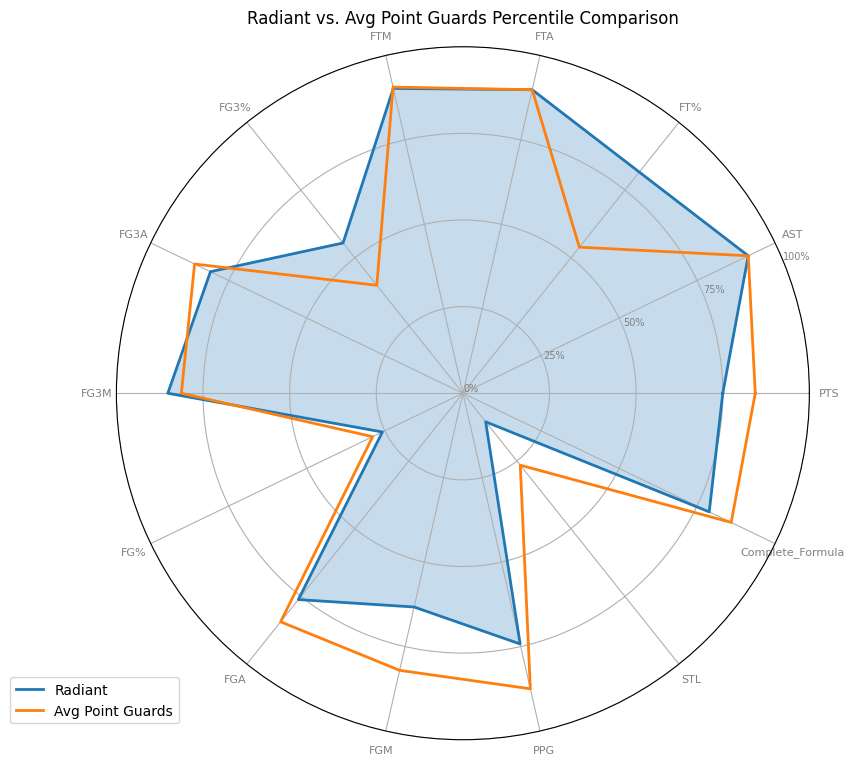

Player: Radiant
PTS: 309 (Player Percentile: 75.00%) (Avg Point Guards Percentile: 84.38%)
AST: 148 (Player Percentile: 91.41%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 33 (Player Percentile: 89.84%) (Avg Point Guards Percentile: 89.84%)
FTM: 33 (Player Percentile: 90.23%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.478 (Player Percentile: 55.47%) (Avg Point Guards Percentile: 39.84%)
FG3A: 138 (Player Percentile: 80.86%) (Avg Point Guards Percentile: 85.94%)
FG3M: 66 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.525 (Player Percentile: 25.78%) (Avg Point Guards Percentile: 28.91%)
FGA: 200 (Player Percentile: 76.17%) (Avg Point Guards Percentile: 84.38%)
FGM: 105 (Player Percentile: 63.28%) (Avg Point Guards Percentile: 82.03%)
PPG: 15.45 (Player Percentile: 74.22%) (Avg Point Guards Percentile: 87.50%)
STL: 8 (Player Percentile: 10.55%) (Avg Point Guards Percentile: 26.56%)
Compl

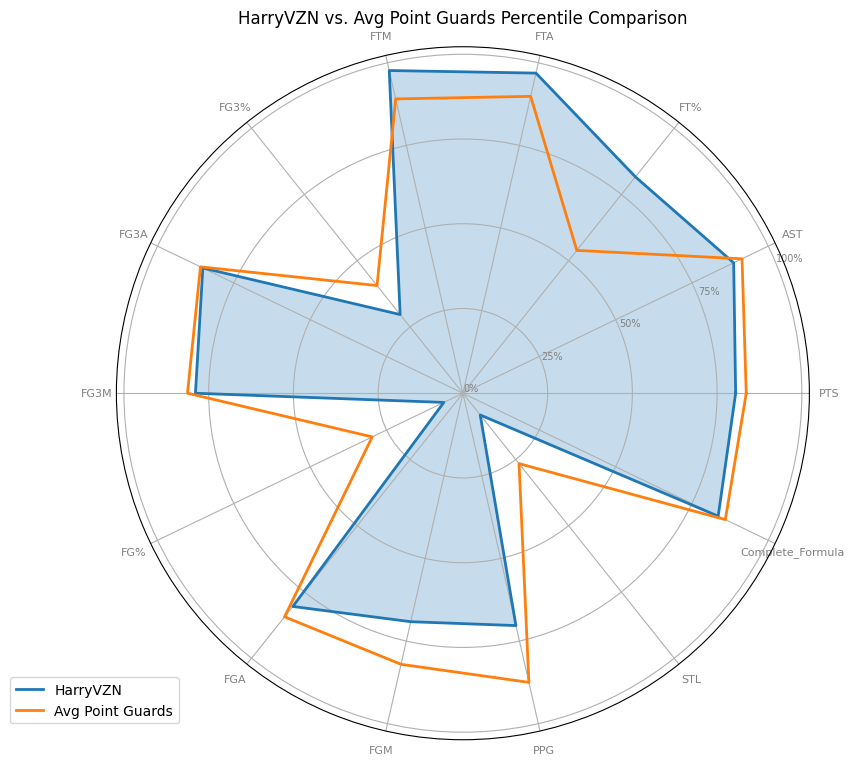

Player: HarryVZN
PTS: 329 (Player Percentile: 80.47%) (Avg Point Guards Percentile: 83.59%)
AST: 140 (Player Percentile: 88.67%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 51 (Player Percentile: 96.88%) (Avg Point Guards Percentile: 89.84%)
FTM: 51 (Player Percentile: 97.66%) (Avg Point Guards Percentile: 89.06%)
FG3%: 0.408 (Player Percentile: 29.69%) (Avg Point Guards Percentile: 40.62%)
FG3A: 142 (Player Percentile: 85.16%) (Avg Point Guards Percentile: 85.94%)
FG3M: 58 (Player Percentile: 78.91%) (Avg Point Guards Percentile: 81.25%)
FG%: 0.464 (Player Percentile: 6.25%) (Avg Point Guards Percentile: 29.69%)
FGA: 237 (Player Percentile: 80.47%) (Avg Point Guards Percentile: 84.38%)
FGM: 110 (Player Percentile: 69.14%) (Avg Point Guards Percentile: 82.03%)
PPG: 14.954545454545455 (Player Percentile: 70.31%) (Avg Point Guards Percentile: 87.50%)
STL: 7 (Player Percentile: 8.20%) (Avg Point Guards Percentile: 2

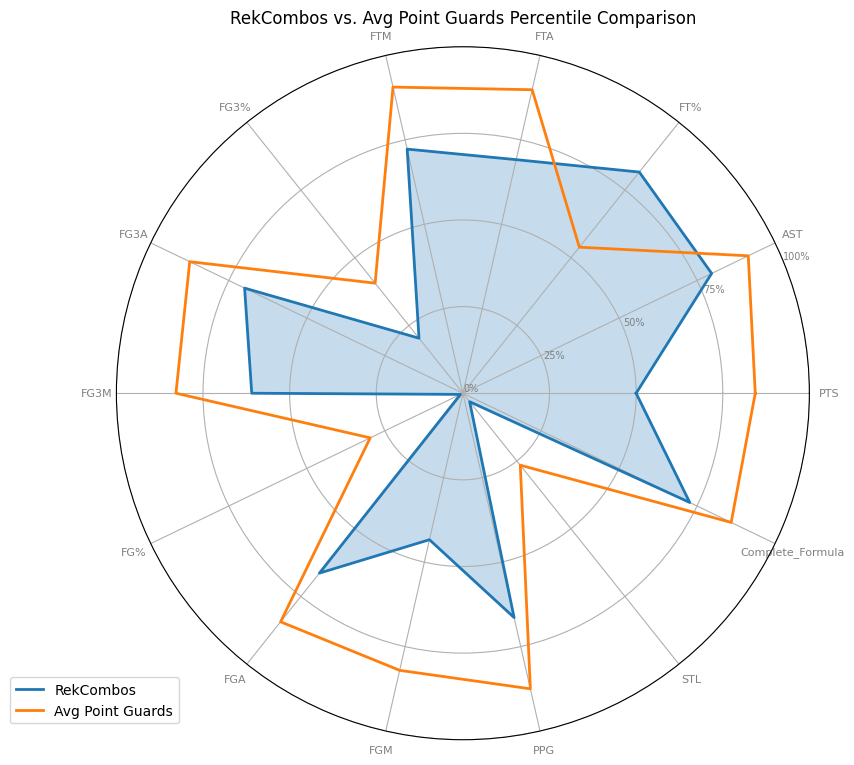

Player: RekCombos
PTS: 214 (Player Percentile: 50.00%) (Avg Point Guards Percentile: 84.38%)
AST: 102 (Player Percentile: 79.69%) (Avg Point Guards Percentile: 91.41%)
FT%: 1.0 (Player Percentile: 81.64%) (Avg Point Guards Percentile: 53.91%)
FTA: 18 (Player Percentile: 69.14%) (Avg Point Guards Percentile: 89.84%)
FTM: 18 (Player Percentile: 72.27%) (Avg Point Guards Percentile: 90.62%)
FG3%: 0.383 (Player Percentile: 20.31%) (Avg Point Guards Percentile: 40.62%)
FG3A: 94 (Player Percentile: 69.92%) (Avg Point Guards Percentile: 87.50%)
FG3M: 36 (Player Percentile: 60.94%) (Avg Point Guards Percentile: 82.81%)
FG%: 0.437 (Player Percentile: 0.78%) (Avg Point Guards Percentile: 29.69%)
FGA: 183 (Player Percentile: 66.41%) (Avg Point Guards Percentile: 84.38%)
FGM: 80 (Player Percentile: 43.36%) (Avg Point Guards Percentile: 82.03%)
PPG: 14.266666666666667 (Player Percentile: 66.41%) (Avg Point Guards Percentile: 87.50%)
STL: 5 (Player Percentile: 3.12%) (Avg Point Guards Percentile: 26

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

# Step 1: Data Preparation
numeric_columns = ['PTS', 'AST', 'FT%', 'FTA', 'FTM', 'FG3%', 'FG3A', 'FG3M', 'FG%', 'FGA', 'FGM', 'PPG', 'STL', 'Complete_Formula']
top_point_guards = all_data[all_data['Pos.'] == 'PG'].nlargest(30, 'PPG')
league_data = all_data[numeric_columns]

# Create angles for radar chart
angles = np.linspace(0, 2 * np.pi, len(numeric_columns), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Loop through each top point guard
for index, player_row in top_point_guards.iterrows():
    player_name = player_row['Player']
    
    # Calculate percentile ranks for the selected player
    player_data = player_row[numeric_columns]
    percentile_ranks_player = [percentileofscore(league_data[column], player_data[column]) for column in numeric_columns]
    percentile_ranks_player = [rank / 100 for rank in percentile_ranks_player]  # Convert to floats
    
    # Calculate average values and percentile ranks for remaining point guards
    avg_point_guards = top_point_guards[top_point_guards['Player'] != player_name][numeric_columns].mean()
    percentile_ranks_avg = [percentileofscore(league_data[column], avg_point_guards[column]) for column in numeric_columns]
    percentile_ranks_avg = [rank / 100 for rank in percentile_ranks_avg]  # Convert to floats
    
    # Create the radar chart
    plt.figure(figsize=(12, 9))  # Adjust the size as needed
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, percentile_ranks_player + [percentile_ranks_player[0]], linewidth=2, label=player_name)
    ax.fill(angles, percentile_ranks_player + [percentile_ranks_player[0]], alpha=0.25)
    ax.plot(angles, percentile_ranks_avg + [percentile_ranks_avg[0]], linewidth=2, label='Avg Point Guards')
    plt.xticks(angles[:-1], numeric_columns, color='grey', size=8)
    plt.yticks(np.linspace(0, 1, 5), ['0%', '25%', '50%', '75%', '100%'], color='grey', size=7)
    
    plt.title(f'{player_name} vs. Avg Point Guards Percentile Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Display the plot
    plt.show()
    
    # Print out the values and percentiles
    print(f"Player: {player_name}")
    for i, column in enumerate(numeric_columns):
        print(f"{column}: {player_data[column]} (Player Percentile: {percentile_ranks_player[i]:.2%}) (Avg Point Guards Percentile: {percentile_ranks_avg[i]:.2%})")
    print("\n")




### Summary of Point Guard Stats 



1. Player: ANT
- Scores exceptionally high in Points per Game (PPG) with a percentile of 100%, indicating that he's a top scorer among point guards.
- His Assist (AST) percentile is also 100%, suggesting his playmaking skills are among the best.
- Performs well in Free Throw Attempts (FTA) and Free Throw Made (FTM), both at 100% percentiles, indicating his effectiveness at drawing fouls and converting free throws.
- Three-Point Percentage (FG3%) is relatively lower at around 39%, while his average FG3A percentile is around 98%, suggesting a higher volume of attempts than successful shots.

2. Player: antoinelove
- Consistently ranks high in various categories like Points per Game (PPG), Assists (AST), and Free Throw Percentage (FT%).
- Demonstrates a strong Three-Point Percentage (FG3%) with a percentile of 75%.
- Despite having a lower Field Goal Percentage (FG%), his scoring efficiency is high due to his strong performance in free throws and three-pointers.

3. Player: unguardable
- Displays remarkable proficiency in Assists (AST) and Free Throw Made (FTM), both with percentiles above 90%.
- Boasts a solid Three-Point Percentage (FG3%) with a percentile of 84%, indicating his effectiveness from beyond the arc.

4. Player: Ky
- Stands out in Assists (AST) with a percentile of 80.86% and Free Throw Attempts (FTA) with a percentile of 85.55%.
- Shows perfection in Free Throw Percentage (FT%), which is impressive compared to other players.

5. Player: Greens
- Performs well across several categories, including Points per Game (PPG) and Assists (AST).
- Shows strength in Three-Point Percentage (FG3%) with a percentile of 78.91%, suggesting proficiency in three-point shooting.

6. Player: CP
- Boasts high rankings in Assists (AST) and Free Throw Attempts (FTA), indicating strong playmaking skills and drawing fouls.
- His consistent performance across multiple metrics contributes to his balanced playstyle.

7. Player: Leche
- Demonstrates a strong Assists (AST) percentile despite having a lower Points per Game (PPG) and Field Goal Percentage (FG%).
- Performs well in Free Throw Percentage (FT%) and Three-Point Percentage (FG3%), indicating versatility in scoring.

8. Player: Ryan1of1
- Shows proficiency in Assists (AST) and Free Throw Made (FTM) with percentiles around 80%.
- Possesses a strong Three-Point Percentage (FG3%) with a percentile of 71.88%, showcasing his three-point shooting ability.

9. Player: Claude
- Performs well in Points per Game (PPG) and Assists (AST) with percentiles around 94%.
- Demonstrates a solid Three-Point Percentage (FG3%) with a percentile of 39.84%, indicating room for improvement in this area.

10. Player: BearDaBeast
- Excels in Points per Game (PPG) and Assists (AST) with percentiles around 96% and 98%, respectively.
- Shows an impressive Three-Point Percentage (FG3%) of 43.2% despite having a relatively lower Field Goal Percentage (FG%).

In [9]:
top_point_guards

Person_id       Player                      Team  GP  Min  FGM  FGA   
105    1630975          ANT                Pistons GT  23  774  231  409  \
56     1641820  antoinelove          Hornets Venom GT  19  640  194  315   
81     1630962  unguardable              Magic Gaming  19  509  188  310   
49     1641578           Ky         Heat Check Gaming  16  459  160  297   
97     1631191       Greens                    NetsGC  18  585  166  281   
39     1641577           CP              Grizz Gaming  18  483  161  281   
24     1641574        Leche  Celtics Crossover Gaming  14  389  124  233   
77     1631277     Ryan1of1             Lakers Gaming  13  360  105  199   
9      1641572       Claude            Blazer5 Gaming  24  819  199  339   
114    1600221  BearDaBeast           T-Wolves Gaming  25  680  213  320   
43     1630406         ceez            Hawks Talon GC  12  336   93  152   
99     1630413   Greenlight             Pacers Gaming  24  824  175  382   
33     1630966       gallow              Gen.G Tigers  24  693  164  323   
2      1630400          Dre                  76ers GC  31  949  197  368   
13     1630955        Cooks              Bucks Gaming  21  636  145  284   

       FG%  FG3M  FG3A  ...  Three_Point_Efficiency  Usage_Efficiency   
105  0.565    88   201  ...                0.241516          0.000091  \
56   0.616    70   136  ...                0.186405          0.000157   
81   0.606    86   159  ...                0.263070          0.000159   
49   0.539    64   142  ...                0.228593          0.000163   
97   0.591    73   140  ...                0.248224          0.000187   
39   0.573    62   131  ...                0.217335          0.000184   
24   0.532    66   141  ...                0.366207          0.000277   
77   0.528    48   107  ...                0.289109          0.000341   
9    0.587    72   164  ...                0.234039          0.000126   
114  0.666    51   118  ...                0.135977          0.000135   
43   0.612    39    73  ...                0.230653          0.000584   
99   0.458    94   234  ...                0.375236          0.000109   
33   0.508    86   201  ...                0.387246          0.000145   
2    0.535   122   254  ...                0.476400          0.000107   
13   0.511    65   158  ...                0.309512          0.000207   

     Shooting_Efficiency  Complete_Formula            PC   Afgm      Pos   
105             0.000022         60.751131  10525.133518  140.0  468.720  \
56              0.000029         38.233118   5562.918638   84.0  363.040   
81              0.000042         42.134621   5940.981611  102.0  357.340   
49              0.000037         35.109918   4213.190206   52.0  364.760   
97              0.000046         35.245831   4388.105910   72.5  334.595   
39              0.000040         36.890495   4454.527303   77.5  337.945   
24              0.000102         26.986969   2509.788111   48.5  276.155   
77              0.000099         26.210084   2064.044144   37.5  251.625   
9               0.000030         48.155057   7187.142328   83.5  407.565   
114             0.000018         45.232750   7225.931821  124.0  383.400   
43              0.000135         19.972917   1393.110971   43.5  189.685   
99              0.000041         47.885555   6284.979099   84.0  437.720   
33              0.000056         43.612452   5364.331542  105.0  371.830   
2               0.000051         51.811377   7655.130888  126.5  433.815   
13              0.000064         38.408040   4176.874379   83.0  315.570   

     Offensive_Rating        PPG       OER  
105       2245.505529  26.565217  0.077424  
56        1532.315623  26.210526  0.067878  
81        1662.557119  26.052632  0.070896  
49        1155.058177  25.812500  0.077177  
97        1311.467867  24.500000  0.059877  
39        1318.121974  24.222222  0.093136  
24         908.833123  23.142857  0.045095  
77         820.285800  21.615385  0.065385

### Ridge Regression Model Setup

Loss(Ridge) = ||Complete_Formula - (β0 + β1 * OREB + β2 * FT% + β3 * FTA + β4 * Three_Point_Efficiency + β5 * Tm_Avg_Ast_Per_Min)||² + α * (β1² + β2² + β3² + β4² + β5²)

**Where:**

- Loss(Ridge) is the loss function for Ridge Regression.
- Complete_Formula is the target variable.
- OREB, FT%, FTA, OREB, and Three_Point_Efficiency are the features (independent variables).
- β0 is the intercept.
- β1, β2, β3, β4, β5, β6 are the coefficients for the respective features.
- α is the regularization parameter (alpha), controlling the strength of regularization.

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler  # Import the scaler

# Assuming 'all_data' is your DataFrame containing the necessary data

# Select relevant columns
off_data = all_data[["Player", "FT%", "FTA", "Three_Point_Efficiency", "Tm_Avg_Ast_Per_Min", "Complete_Formula", "OREB"]]
predict = "Complete_Formula"

# One-hot encode categorical variables
#encoded_data = pd.get_dummies(off_data, columns=[ "Pos."])

# Separate features and target variable
X = off_data.drop([predict, "Player"], axis=1)
y = off_data[predict]


# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features

# Splitting the scaled dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a Ridge Regression model
alpha = 4.2  # Regularization strength, adjust as needed
ridge = Ridge(alpha=alpha)
ridge.fit(x_train, y_train)

# Predicting on the entire dataset
all_predictions = ridge.predict(X_scaled)  # Use scaled features for predictions

# Creating a DataFrame with player names, projected points, and actual points
player_names = off_data["Player"]
player_projections = pd.DataFrame({"Player": player_names, "Projected_PTS": all_predictions, "Actual_PTS": y})

# Sort the DataFrame by projected points in descending order
player_projections_sorted = player_projections.sort_values(by="Projected_PTS", ascending=False)

# Display the sorted projections
print(player_projections_sorted)



           Player  Projected_PTS  Actual_PTS
105           ANT      54.640795   60.751131
114   BearDaBeast      54.534698   45.232750
2             Dre      51.495414   51.811377
9          Claude      46.915455   48.155057
1             630      46.643814   52.744261
..            ...            ...         ...
20           Colt       5.906320    7.213399
60          Kaaze       5.433168    7.935299
42       Gradient       4.118704    5.804499
45         DeJuan       3.990749    4.821681
74   FutureClutch       3.795716    2.427746

[128 rows x 3 columns]


#### Error Metrics

- MAE: The average absolute difference between the predicted and actual values is approximately 5.08. This means, on average, your predictions are off by about 5.08 units of the Complete_Formula value.
- MSE: The average squared difference between predictions and actual values is about 39.95. Squaring the errors emphasizes larger deviations more than smaller ones.
- RMSE: The square root of the MSE is approximately 6.32. This indicates that, on average, your predictions deviate from the actual values by about 6.32 units.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(y, all_predictions)
mse = mean_squared_error(y, all_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 4.151684418453643
Mean Squared Error: 27.312549540160706
Root Mean Squared Error: 5.226140979744108


#### R-Squared

1. R² Score (Coefficient of Determination):

- The R² score measures the proportion of the variance in the dependent variable (target) that is explained by the independent variables (features) in your model.
- It ranges from 0 to 1. A higher R² indicates that a larger proportion of the variance in the target variable is explained by the model.
- An R² score of approximately 0.844 means that the Ridge Regression model explains about 84.4% of the variance in the Complete_Formula target variable.

2. Adjusted R²:

- Adjusted R² is a modified version of the R² score that accounts for the number of independent variables in the model.
- It adjusts the R² score based on the number of features and the sample size, preventing it from artificially increasing as more features are added.
 - A higher Adjusted R² indicates a better balance between model complexity and explanatory power.
- An Adjusted R² of approximately 0.815 indicates that around 81.5% of the variance in the Complete_Formula target variable is explained by the independent variables while accounting for the model's complexity.

In [12]:
# Calculate R² score
r2 = ridge.score(x_test, y_test)

#Calculate number of predictors
num_predictors = x_test.shape[1]

# Calculate the number of data points
num_data_points = len(y_test)

# Calculate the adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (num_data_points - 1) / (num_data_points - num_predictors - 1)

print("R² Score:", r2)
print("Adj. R²:", adjusted_r2)

R² Score: 0.8504285397811313
Adj. R²: 0.8130356747264141


### Correlation

                             FT%       FTA  Three_Point_Efficiency   
FT%                     1.000000  0.377103               -0.199667  \
FTA                     0.377103  1.000000                0.013042   
Three_Point_Efficiency -0.199667  0.013042                1.000000   
Tm_Avg_Ast_Per_Min      0.047215  0.308945                0.038335   
Complete_Formula        0.335172  0.848659                0.146515   
OREB                    0.084523 -0.134346               -0.650741   

                        Tm_Avg_Ast_Per_Min  Complete_Formula      OREB  
FT%                               0.047215          0.335172  0.084523  
FTA                               0.308945          0.848659 -0.134346  
Three_Point_Efficiency            0.038335          0.146515 -0.650741  
Tm_Avg_Ast_Per_Min                1.000000          0.486123  0.156829  
Complete_Formula                  0.486123          1.000000 -0.283125  
OREB                              0.156829         -0.283125  1.000000 

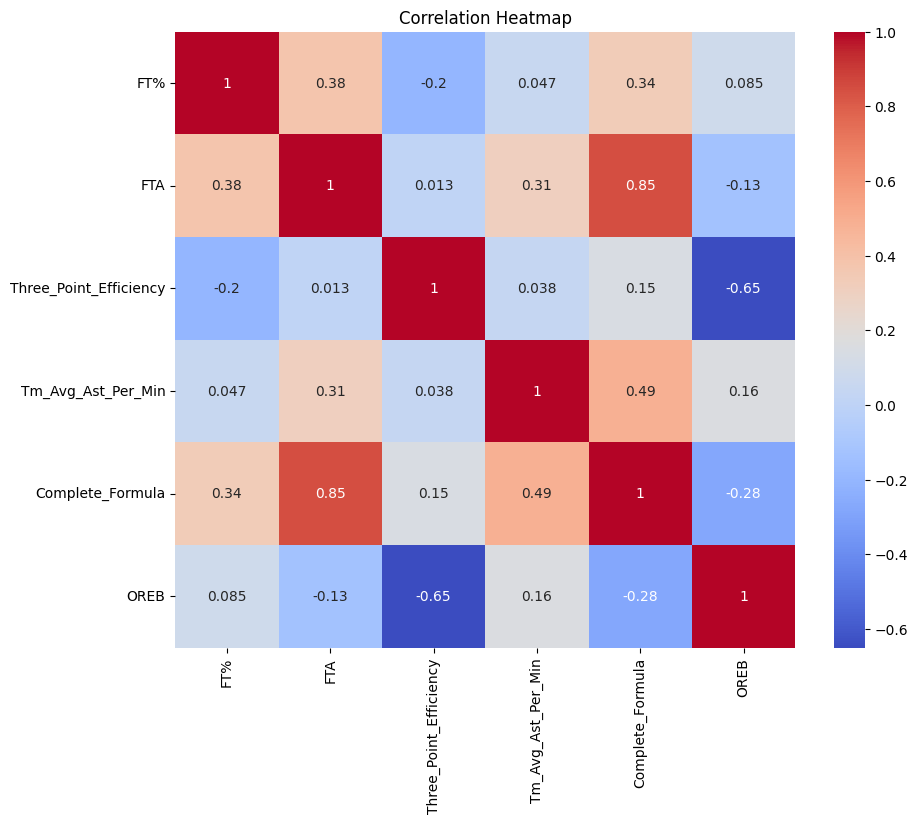

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = off_data.drop(["Player"], axis=1).corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Coefficients

In [14]:
# Get coefficients and corresponding feature names
coefficients = ridge.coef_
feature_names = X.columns

# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Display the coefficients
print(coef_df)

                  Feature  Coefficient
1                     FTA     7.580018
3      Tm_Avg_Ast_Per_Min     4.090136
0                     FT%     1.260835
2  Three_Point_Efficiency    -0.566864
4                    OREB    -3.361866


#### Variance Inflation Factor and Eigenvalues

In [15]:
# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = feature_names  # feature_names from previous code
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Calculate eigenvalues
eigenvalues, _ = np.linalg.eig(correlation_matrix)

print("\nVIF Data:\n", vif_data)
print("\nEigenvalues:", eigenvalues)



VIF Data:
                   Feature       VIF
0                     FT%  6.810283
1                     FTA  2.894125
2  Three_Point_Efficiency  4.616704
3      Tm_Avg_Ast_Per_Min  8.987935
4                    OREB  2.649349

Eigenvalues: [2.3424855  1.72495726 0.99491597 0.55281156 0.09736257 0.28746713]


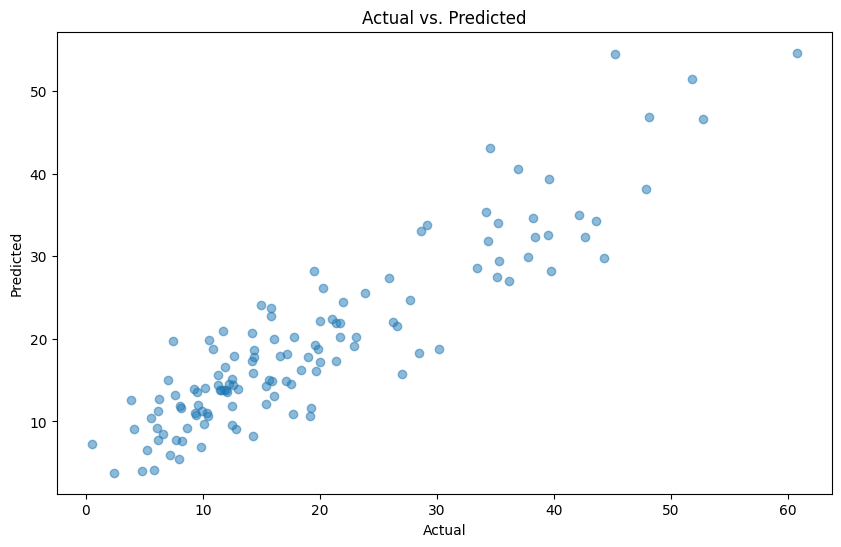

In [16]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, all_predictions, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

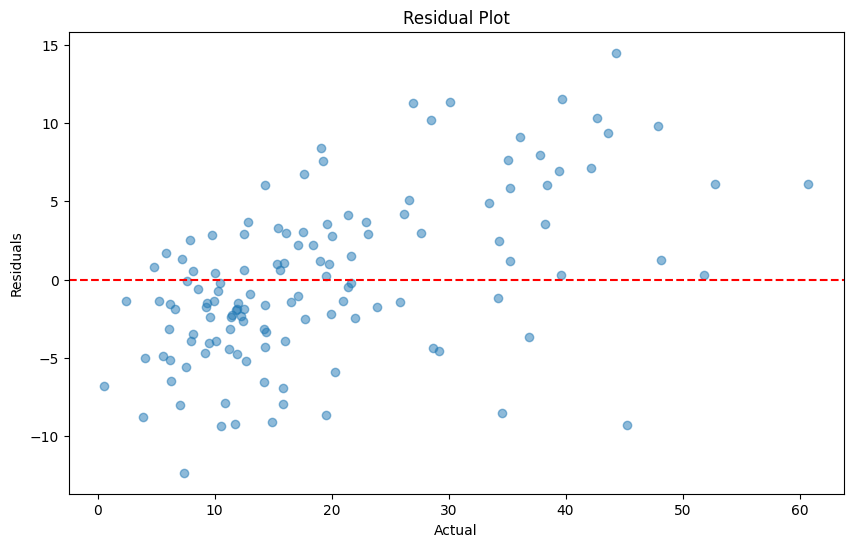

In [17]:
residuals = y - all_predictions

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


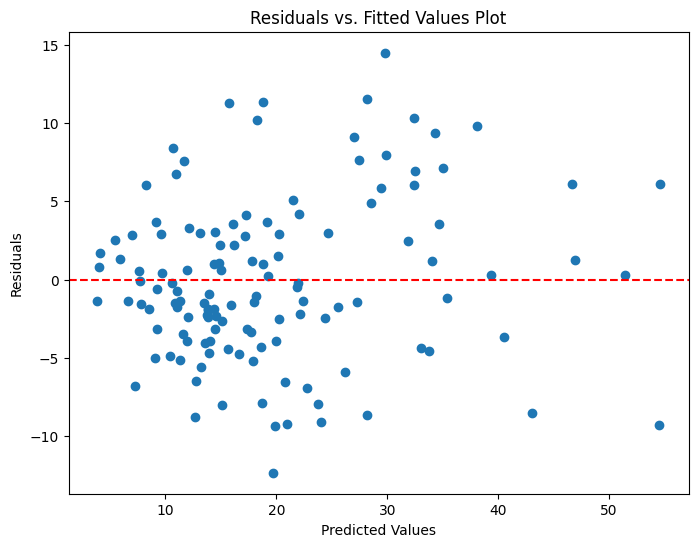

In [18]:
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(all_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

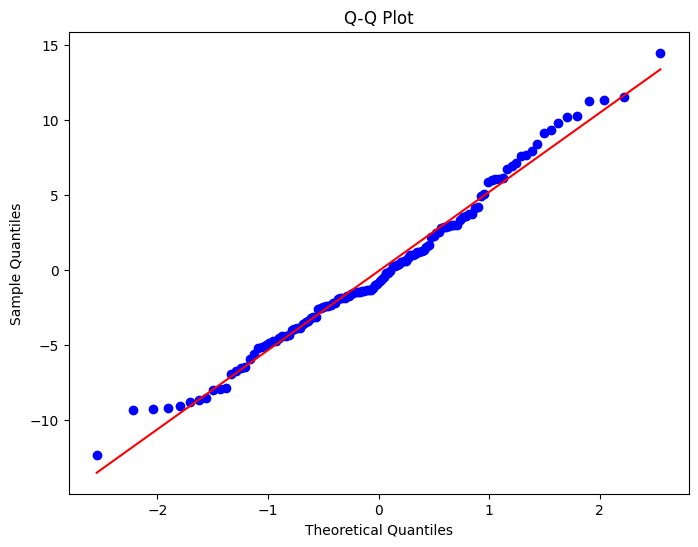

In [19]:
# Q-Q Plot
import scipy.stats as stats
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

Cross Validation

In [20]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(ridge, X, y, cv=5, scoring='r2')  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Average Cross-Validation R² Score:", np.mean(cv_scores))

Cross-Validation R² Scores: [0.8874427  0.78696563 0.86191014 0.74931595 0.74759162]
Average Cross-Validation R² Score: 0.8066452087021132


### Hyper Parameter Tuning 

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge

# Define the alpha values you want to try
alpha_values = np.arange(0.1, 100.1, 0.1)  # Start from 0.1, end at 100.1 (exclusive), step size 0.1

# Perform grid search to find the best alpha value
grid_search = GridSearchCV(ridge, param_grid={'alpha': alpha_values}, cv=5)
grid_search.fit(x_train, y_train)

# Print the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best Alpha:", best_alpha)

Best Alpha: 4.2


### Regularization Path

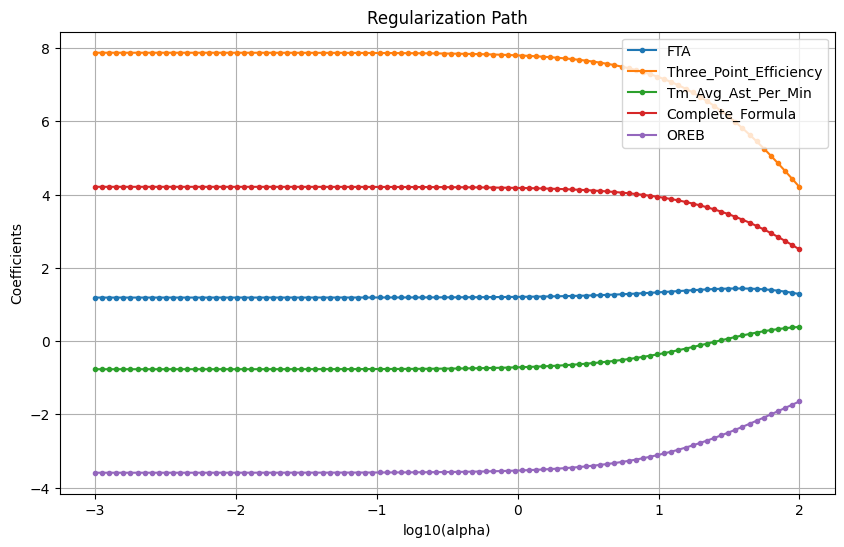

In [22]:
# Define a range of alpha values
alpha_values = np.logspace(-3, 2, num=100)  # Generate alpha values on a logarithmic scale

# Initialize an empty list to store coefficient paths
coefs = []

# Fit Ridge Regression models for each alpha value
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)

# Convert the list of coefficient paths to a NumPy array
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alpha_values), coefs, marker='o', markersize=3)
plt.xlabel('log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Regularization Path')
plt.legend(off_data.columns[2:])  # Assuming columns 2 onward are feature names
plt.grid(True)
plt.show()

In [23]:
from tabulate import tabulate

# Display the sorted projections as a table
table_data = []
for index, row in player_projections_sorted.iterrows():
    player_name = row["Player"]
    projected_pts = row["Projected_PTS"]
    actual_pts = row["Actual_PTS"]
    player_position = all_data.loc[all_data["Player"] == player_name, "Pos."].values[0]  
    team = all_data.loc[all_data["Player"] == player_name, "Team"].values[0]  
    
    table_data.append([player_name, player_position, projected_pts, actual_pts, team])

table_headers = ["Player", "Position", "Projected PTS", "Actual PTS", "Team"]
table = tabulate(table_data, headers=table_headers, floatfmt=(".0f", None, ".2f", ".2f"), tablefmt="pretty")

print(table)

+-----------------+----------+--------------------+--------------------+--------------------------+
|     Player      | Position |   Projected PTS    |     Actual PTS     |           Team           |
+-----------------+----------+--------------------+--------------------+--------------------------+
|       ANT       |    PG    | 54.64079464862223  | 60.75113141489012  |        Pistons GT        |
|   BearDaBeast   |    PG    | 54.53469791377689  | 45.23275005059064  |     T-Wolves Gaming      |
|       Dre       |    PG    | 51.49541401690493  | 51.811376566116316 |         76ers GC         |
|     Claude      |    PG    | 46.91545466723545  | 48.15505747327582  |      Blazer5 Gaming      |
|       630       |    SG    | 46.643813880261725 | 52.744260864667474 |         76ers GC         |
|    HarryVZN     |    PG    | 43.092677290444215 | 34.56085064525016  |      NBL Oz Gaming       |
|       CP        |    PG    | 40.52349009020976  | 36.89049526653448  |       Grizz Gaming       |


**This metric seeks to quantify a player's offensive contribution and efficiency by taking into account various factors related to their offensive performance. Let's break down the different components of the formula and discuss what each part represents:**

1. TmAst/TmFGM: This ratio represents the proportion of team assists to team field goals made. It indicates the degree to which a player's made field goals are assisted by their teammates. A higher value suggests that the player's scoring is heavily dependent on assists, while a lower value indicates a greater ability to create scoring opportunities on their own.

2. 1.53 - 1.442 * [Ast/Min / (TmAst/(TmMin/5))]: This part of the formula focuses on the player's assist efficiency relative to the team's average. It quantifies how well the player assists compared to team norms. The ratio [Ast/Min / (TmAst/(TmMin/5))] compares the player's assists per minute with the team's average assists per minute. The coefficient values (1.53 and 1.442) adjust the impact of this ratio on the overall metric.

3. *-0.041 * ((OReb/Min)48): This component accounts for the player's offensive rebounding efficiency. It considers how effective the player is at gathering offensive rebounds, adjusting for the amount of time they spend on the court. The coefficient values (-0.041) apply a penalty based on offensive rebounding.

4. -0.787 * Usage: Usage is a measure of a player's involvement in their team's offense. Higher usage indicates that the player is taking a larger portion of their team's offensive possessions. The coefficient value (-0.787) introduces a penalty for higher usage, suggesting that players with high usage might have lower efficiency.

5. 0.014 * (3A/FGA)^2 * (1/Usage)^2: This term considers the player's three-point shooting efficiency and how it relates to their overall usage. The component (3A/FGA)^2 represents the ratio of three-point attempts to total field goal attempts, squared. This ratio captures the player's reliance on three-point shots. The (1/Usage)^2 term balances the impact of usage on the efficiency. The coefficient value (0.014) adjusts the influence of this term.

When you combine all these components together, the resulting value represents an offensive efficiency metric for a player. This metric attempts to capture the player's ability to score, create assists, secure offensive rebounds, and make efficient use of possessions while accounting for usage patterns. It's a comprehensive way to assess a player's offensive impact and efficiency on the  court.